# using the CapsLayer module

In [1]:
import numpy as np
import tensorflow as tf
import os
import struct
import matplotlib.pyplot as plt
from layers.CapsLayer import CapsLayer
from layers.ConvCapsLayer import ConvCapsLayer
from layers.ConvLayer import ConvLayer
from layers.DenseLayer import DenseLayer

/home/luke/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
class MNIST():
    def __init__(self, directory):
        self._directory = directory
        
        self._training_data = self._load_binaries("./train-images.idx3-ubyte")
        self._training_labels = self._load_binaries("./train-labels.idx1-ubyte")
        self._test_data = self._load_binaries("./t10k-images.idx3-ubyte")
        self._test_labels = self._load_binaries("./t10k-labels.idx1-ubyte")
        
        np.random.seed(0)
        samples_n = self._training_labels.shape[0]
        random_indices = np.random.choice(samples_n, samples_n // 10, replace = False)
        np.random.seed()
        
        self._validation_data = self._training_data[random_indices]
        self._validation_labels = self._training_labels[random_indices]
        self._training_data = np.delete(self._training_data, random_indices, axis = 0)
        self._training_labels = np.delete(self._training_labels, random_indices)
    
    def _load_binaries(self, file_name):
        path = os.path.join(self._directory, file_name)
        
        with open(path, 'rb') as fd:
            check, items_n = struct.unpack(">ii", fd.read(8))

            if "images" in file_name and check == 2051:
                height, width = struct.unpack(">II", fd.read(8))
                images = np.fromfile(fd, dtype = 'uint8')
                return np.reshape(images, (items_n, height, width))
            elif "labels" in file_name and check == 2049:
                return np.fromfile(fd, dtype = 'uint8')
            else:
                raise ValueError("Not a MNIST file: " + path)
    
    
    def get_training_batch(self, batch_size):
        return self._get_batch(self._training_data, self._training_labels, batch_size)
    
    def get_validation_batch(self, batch_size):
        return self._get_batch(self._validation_data, self._validation_labels, batch_size)
    
    def get_test_batch(self, batch_size):
        return self._get_batch(self._test_data, self._test_labels, batch_size)
    
    def _get_batch(self, data, labels, batch_size):
        samples_n = labels.shape[0]
        if batch_size <= 0:
            batch_size = samples_n
        
        random_indices = np.random.choice(samples_n, samples_n, replace = False)
        data = data[random_indices]
        labels = labels[random_indices]
        for i in range(samples_n // batch_size):
            on = i * batch_size
            off = on + batch_size
            yield data[on:off], labels[on:off]
    
    
    def get_sizes(self):
        training_samples_n = self._training_labels.shape[0]
        validation_samples_n = self._validation_labels.shape[0]
        test_samples_n = self._test_labels.shape[0]
        return training_samples_n, validation_samples_n, test_samples_n

In [3]:
#STORING THE DATA
mnist_data = MNIST('/home/luke/data/mnist/')

In [4]:
#INVESTIGATING THE DATA
'''
for i, batch in enumerate(mnist_data.get_training_batch(1)):
    print(batch)
    if i > 1:
        break
'''       


'\nfor i, batch in enumerate(mnist_data.get_training_batch(1)):\n    print(batch)\n    if i > 1:\n        break\n'

In [5]:
#HYPERPARAMETERS

#TRAINING PARAMS
batch_size = 128


In [11]:
def calculate_loss_accuracy(digit_caps, labels):
    
    length_digit_caps = tf.norm(digit_caps, axis = 2)
    labels_one_hot = tf.one_hot(labels, depth=10)
    
   
    plus_loss =  labels_one_hot * tf.nn.relu(0.9 - length_digit_caps)
    minus_loss = 0.5 * (1 - labels_one_hot) * \
                        tf.nn.relu(length_digit_caps - 0.1)
    
    loss = tf.reduce_sum(plus_loss + minus_loss, axis=-1)
    loss = tf.reduce_mean(loss)
    
    correct_prediction = tf.equal(tf.argmax(length_digit_caps, 1), labels)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    return loss, accuracy


def mask_and_flatten_digit_caps(digit_caps, labels):
    
    labels = tf.one_hot(labels, depth=10)
    print(labels.get_shape())
    labels = tf.expand_dims(labels, axis=-1)
    print(labels.get_shape())
    labels = tf.tile(labels, [1,1,16])
    print(labels.get_shape())
    masked_digit_caps = digit_caps * labels
    print(masked_digit_caps.get_shape())
    
    return tf.reshape(masked_digit_caps, shape=[batch_size,10*16]) 


def calculate_reconstruction_loss(reconstructions, images):
    
    images = images/255.0
    images_flatten = tf.reshape(images, shape=[batch_size, 784])
    squared_error = tf.squared_difference(reconstructions, images_flatten)
    sse = tf.reduce_sum(squared_error, axis=-1)
    
    return 0.0005 * tf.reduce_mean(sse)
    

In [12]:
#DESCIRBING THE DATAFLOW GRAPH

tf.reset_default_graph()

# define the placeholders
images = tf.placeholder(dtype=tf.float32, shape=[batch_size, 28, 28])
images_exp = tf.expand_dims(images, axis=-1)
labels = tf.placeholder(dtype=tf.int64, shape=[batch_size])


with tf.variable_scope('ReLU_Conv1'):
    conv_layer = ConvLayer(
                    kernel_size = 9,
                    stride = 1,
                    padding = 'VALID',
                    channels = 256,
                    activation_function = 'ReLU' 
                 )
    conv = conv_layer(images_exp)

    
with tf.variable_scope('Primary_Caps'):
    primary_caps_layer = ConvCapsLayer(
                            kernel_size = 9,
                            stride = 2,
                            padding = 'VALID',
                            dimension = 8,
                            channels = 32,
                        )
    primary_caps = primary_caps_layer(conv)

    
with tf.variable_scope('Digit_Caps'):
    digit_caps_layer = CapsLayer(
                            count1 = 6*6*32,
                            dim1 = 8,
                            count2 = 10,
                            dim2 = 16,
                            rout_iter = 3
                        )
    digit_caps = digit_caps_layer(primary_caps)


with tf.variable_scope('Loss'):
    loss, accuracy = calculate_loss_accuracy(digit_caps, labels)
    

#RECONSTRUCTOR

# flatten and mask the digit capsules
digit_caps_flat = mask_and_flatten_digit_caps(digit_caps,
                                                labels
                                                )

with tf.variable_scope('Dense1'):
    dense_1_layer = DenseLayer(
                        n_out = 512,
                        activation_function = 'ReLU'
                    )
    dense_1 = dense_1_layer(digit_caps_flat)
    

with tf.variable_scope('Dense2'):
    dense_2_layer = DenseLayer(
                        n_out = 1024,
                        activation_function = 'ReLU'
                    )
    dense_2 = dense_2_layer(dense_1)

    
with tf.variable_scope('Dense3'):
    dense_3_layer = DenseLayer(
                        n_out = 28*28,
                        activation_function = 'Sigmoid'
                    )
    dense_3 = dense_3_layer(dense_2)
    reconstructions = tf.reshape(dense_3, shape=[batch_size, 28, 28])
    
    
with tf.variable_scope('Reconstruction_Loss'):
    reconstruction_loss = calculate_reconstruction_loss(dense_3, images)
    

with tf.variable_scope('Optimizer'):
    optimizer = tf.train.AdamOptimizer()
    training_step = optimizer.minimize(loss+reconstruction_loss)
    
    


#SUMMARIES
tf.summary.scalar('loss', loss)

merged_summaries = tf.summary.merge_all()
    

(128, 10)
(128, 10, 1)
(128, 10, 16)
(128, 10, 16)


Step 1: Loss: 3.352714776992798, Accuracy: 0.125
[-0.         -0.         -0.         -0.          0.         -0.         -0.
 -0.         -0.         -0.          0.         -0.         -0.          0.
  0.         -0.          0.         -0.          0.          0.         -0.
 -0.          0.          0.         -0.          0.          0.          0.
 -0.         -0.         -0.         -0.         -0.          0.          0.
  0.          0.          0.         -0.         -0.          0.         -0.
  0.          0.          0.          0.         -0.          0.          0.
 -0.          0.          0.          0.          0.          0.         -0.
 -0.         -0.          0.         -0.          0.         -0.         -0.
 -0.         -0.          0.         -0.          0.         -0.          0.
 -0.         -0.         -0.          0.          0.          0.         -0.
 -0.          0.         -0.          0.1156697  -0.23789918 -0.20122971
  0.15593632 -0.32800752  0.294

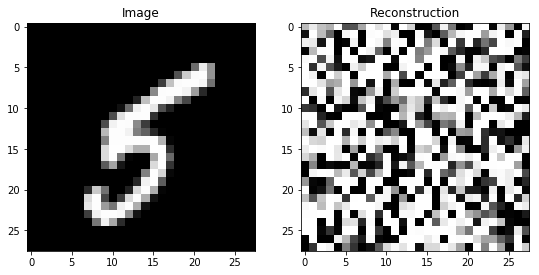

Step 2: Loss: 3.381157159805298, Accuracy: 0.109375
[ 0.         -0.          0.          0.         -0.          0.         -0.
  0.         -0.          0.         -0.         -0.          0.         -0.
 -0.         -0.         -0.          0.         -0.         -0.          0.
 -0.         -0.          0.          0.         -0.         -0.         -0.
  0.         -0.          0.          0.         -0.22223568  0.12453941
 -0.0010731  -0.24601369  0.1400443  -0.18069623  0.24476328 -0.30070475
 -0.23567633  0.02403169 -0.19315594 -0.13151827 -0.36399242 -0.16421555
  0.30095607 -0.28208783 -0.          0.         -0.         -0.          0.
 -0.          0.          0.          0.         -0.         -0.          0.
  0.          0.          0.         -0.          0.          0.         -0.
 -0.          0.         -0.         -0.          0.          0.         -0.
 -0.          0.          0.         -0.         -0.          0.         -0.
  0.         -0.          0.        

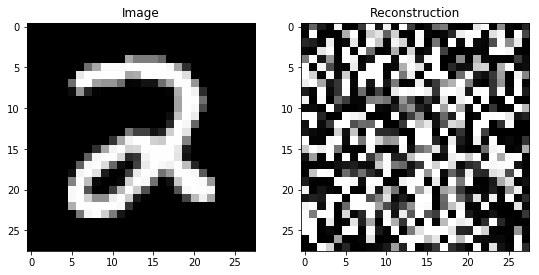

Step 3: Loss: 3.0414514541625977, Accuracy: 0.078125
[ 0.         -0.          0.          0.         -0.          0.         -0.
 -0.         -0.          0.         -0.         -0.          0.          0.
  0.          0.         -0.         -0.         -0.         -0.          0.
  0.         -0.         -0.         -0.          0.         -0.          0.
  0.         -0.          0.          0.         -0.          0.         -0.
 -0.          0.         -0.          0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.          0.         -0.          0.
 -0.         -0.          0.         -0.         -0.         -0.          0.
  0.          0.         -0.          0.          0.          0.         -0.
 -0.          0.          0.          0.          0.          0.         -0.
 -0.          0.         -0.         -0.         -0.          0.          0.
  0.         -0.         -0.          0.          0.          0.         -0.
 -0.         -0.       

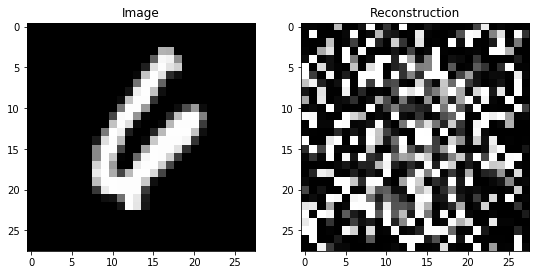

Step 4: Loss: 2.5906693935394287, Accuracy: 0.1328125
[ 0.         -0.          0.          0.         -0.          0.         -0.
 -0.         -0.          0.         -0.         -0.          0.         -0.
  0.          0.          0.         -0.          0.          0.         -0.
 -0.          0.         -0.         -0.         -0.          0.         -0.
  0.          0.          0.          0.         -0.03451345  0.30548781
  0.03135312 -0.0709921   0.12115151 -0.14274175  0.26019329 -0.02578659
 -0.25552413 -0.23064598 -0.28043494 -0.24876991 -0.20691912 -0.10510227
  0.24581341 -0.42441544 -0.         -0.          0.          0.          0.
  0.          0.         -0.         -0.          0.          0.         -0.
  0.          0.         -0.          0.         -0.         -0.         -0.
 -0.          0.          0.          0.         -0.          0.          0.
 -0.          0.         -0.          0.         -0.          0.          0.
 -0.          0.         -0.      

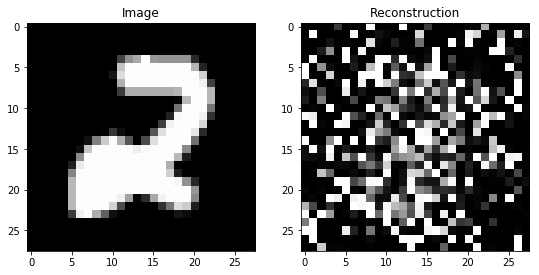

Step 5: Loss: 2.349458694458008, Accuracy: 0.0859375
[ 0.0599452  -0.11275091  0.21538149  0.13313311 -0.21318722 -0.08691648
 -0.49257392 -0.18216719 -0.36598447  0.2045527  -0.32182246 -0.05680947
  0.30129164 -0.13160005 -0.04907361  0.03206175 -0.          0.          0.
  0.          0.         -0.         -0.         -0.          0.          0.
 -0.         -0.         -0.          0.         -0.         -0.          0.
  0.          0.          0.         -0.         -0.          0.          0.
 -0.         -0.         -0.         -0.         -0.         -0.          0.
 -0.         -0.          0.         -0.          0.         -0.          0.
 -0.         -0.         -0.         -0.          0.          0.          0.
 -0.          0.          0.          0.         -0.         -0.          0.
 -0.          0.         -0.          0.          0.         -0.         -0.
  0.          0.          0.          0.         -0.          0.         -0.
  0.          0.          0.   

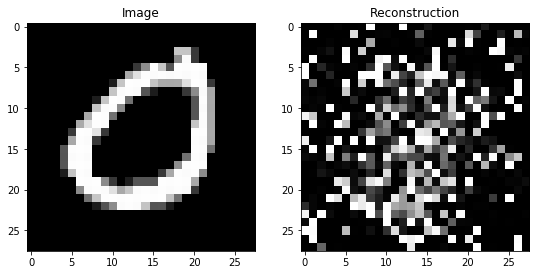

Step 6: Loss: 1.9760183095932007, Accuracy: 0.0859375
[ 0.          0.          0.          0.         -0.          0.         -0.
  0.         -0.          0.         -0.         -0.          0.         -0.
  0.          0.         -0.          0.         -0.          0.         -0.
 -0.         -0.          0.          0.          0.          0.          0.
 -0.         -0.          0.         -0.          0.          0.          0.
 -0.          0.          0.         -0.          0.          0.          0.
 -0.         -0.         -0.         -0.         -0.         -0.
  0.09658157  0.18875255 -0.09675556 -0.10018437 -0.06465106  0.12318187
  0.06899437 -0.13075861  0.1318832   0.03390227  0.00722403 -0.02377259
  0.01832497  0.01370597 -0.00794059 -0.09984778  0.          0.          0.
 -0.         -0.          0.          0.          0.         -0.         -0.
  0.          0.         -0.         -0.          0.          0.          0.
  0.         -0.          0.          0.  

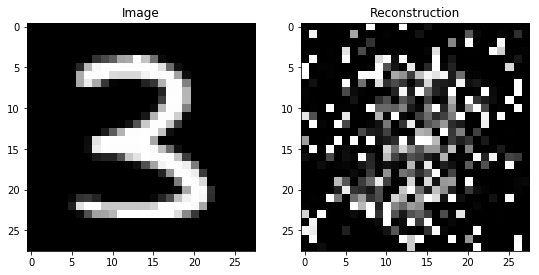

Step 7: Loss: 1.7419499158859253, Accuracy: 0.1953125
[-0.          0.          0.         -0.         -0.          0.         -0.
  0.         -0.          0.          0.          0.          0.         -0.
 -0.          0.         -0.         -0.          0.          0.         -0.
 -0.         -0.          0.         -0.         -0.          0.          0.
  0.          0.         -0.          0.         -0.         -0.          0.
  0.         -0.         -0.         -0.          0.          0.         -0.
 -0.          0.          0.          0.         -0.          0.          0.
  0.          0.          0.         -0.         -0.          0.          0.
 -0.          0.         -0.         -0.          0.          0.         -0.
 -0.         -0.          0.          0.          0.          0.         -0.
 -0.          0.         -0.          0.          0.          0.          0.
 -0.         -0.          0.         -0.          0.          0.         -0.
 -0.         -0.      

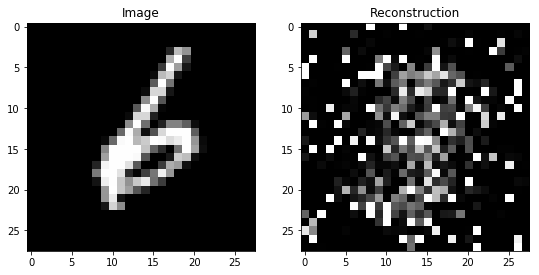

Step 8: Loss: 1.3171226978302002, Accuracy: 0.3125
[ 0.          0.          0.         -0.          0.         -0.         -0.
 -0.         -0.         -0.          0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.          0.         -0.          0.
  0.          0.          0.         -0.          0.         -0.         -0.
  0.         -0.         -0.          0.         -0.         -0.         -0.
  0.         -0.         -0.         -0.         -0.          0.         -0.
 -0.          0.          0.          0.          0.          0.          0.
 -0.         -0.          0.          0.         -0.         -0.          0.
  0.          0.         -0.          0.          0.          0.         -0.
  0.         -0.          0.         -0.         -0.          0.         -0.
  0.         -0.          0.          0.          0.         -0.          0.
  0.         -0.         -0.          0.         -0.         -0.         -0.
  0.         -0.         

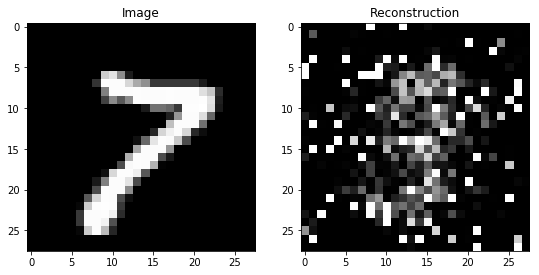

Step 9: Loss: 1.1795603036880493, Accuracy: 0.359375
[ 0.         -0.         -0.          0.          0.         -0.         -0.
 -0.         -0.          0.         -0.         -0.          0.          0.
  0.         -0.          0.         -0.          0.          0.          0.
  0.          0.         -0.          0.          0.         -0.         -0.
  0.         -0.         -0.         -0.          0.          0.         -0.
  0.          0.          0.         -0.         -0.         -0.          0.
 -0.          0.         -0.         -0.          0.          0.         -0.
 -0.          0.          0.          0.          0.         -0.         -0.
 -0.         -0.          0.          0.          0.         -0.         -0.
 -0.          0.         -0.         -0.          0.         -0.         -0.
 -0.          0.          0.         -0.         -0.          0.          0.
  0.         -0.         -0.          0.          0.          0.         -0.
 -0.         -0.       

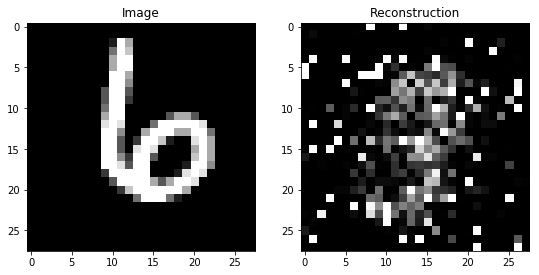

Step 10: Loss: 1.1390769481658936, Accuracy: 0.375
[-0.         -0.         -0.         -0.          0.          0.          0.
  0.          0.         -0.          0.          0.          0.          0.
  0.          0.          0.         -0.          0.          0.         -0.
 -0.          0.         -0.         -0.          0.          0.         -0.
  0.         -0.          0.         -0.          0.          0.         -0.
 -0.          0.          0.          0.         -0.         -0.          0.
  0.         -0.         -0.         -0.         -0.          0.          0.
  0.         -0.         -0.         -0.          0.          0.         -0.
  0.         -0.          0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.          0.         -0.          0.
  0.         -0.          0.         -0.         -0.         -0.         -0.
 -0.          0.          0.          0.         -0.          0.          0.
  0.          0.         

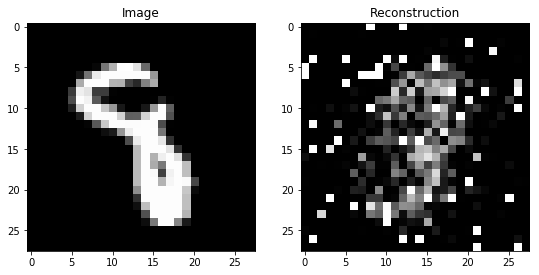

Step 11: Loss: 0.9605492949485779, Accuracy: 0.4609375
[-0.          0.         -0.         -0.         -0.          0.          0.
  0.          0.          0.          0.          0.          0.         -0.
  0.          0.          0.          0.          0.         -0.         -0.
 -0.         -0.         -0.          0.          0.          0.          0.
 -0.          0.          0.          0.         -0.         -0.          0.
 -0.         -0.         -0.          0.          0.         -0.         -0.
 -0.         -0.          0.         -0.         -0.         -0.          0.
  0.         -0.         -0.         -0.          0.          0.         -0.
 -0.         -0.          0.         -0.         -0.         -0.          0.
  0.          0.         -0.         -0.          0.         -0.          0.
  0.          0.         -0.         -0.         -0.          0.         -0.
  0.          0.          0.         -0.         -0.         -0.          0.
  0.          0.     

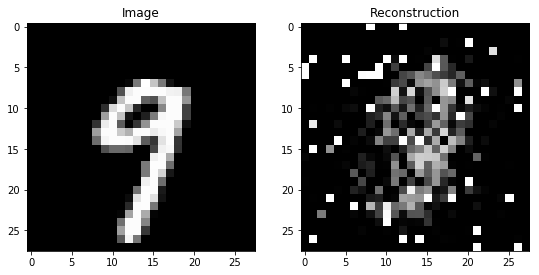

Step 12: Loss: 0.8373795747756958, Accuracy: 0.5625
[-0.          0.          0.         -0.          0.         -0.          0.
 -0.         -0.         -0.          0.         -0.         -0.         -0.
 -0.         -0.          0.         -0.         -0.         -0.         -0.
 -0.          0.          0.          0.          0.         -0.          0.
  0.          0.          0.          0.         -0.          0.          0.
 -0.         -0.         -0.          0.          0.          0.         -0.
 -0.         -0.          0.         -0.         -0.         -0.         -0.
  0.         -0.          0.         -0.         -0.          0.          0.
  0.          0.         -0.         -0.         -0.         -0.         -0.
 -0.          0.         -0.         -0.          0.          0.          0.
 -0.          0.         -0.         -0.          0.          0.          0.
  0.          0.          0.         -0.          0.         -0.          0.
 -0.          0.        

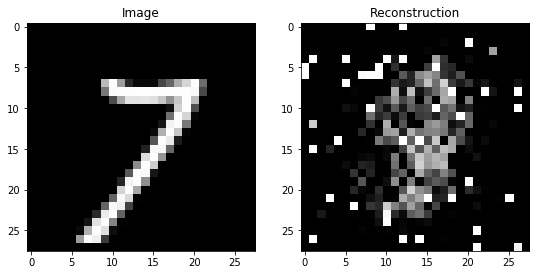

Step 13: Loss: 0.8878202438354492, Accuracy: 0.40625
[-0.          0.          0.          0.          0.         -0.          0.
 -0.         -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.          0.         -0.         -0.         -0.         -0.
  0.          0.         -0.          0.         -0.02847345  0.03564962
  0.15296403 -0.04222532  0.02778877  0.04870518  0.01848049  0.09039298
  0.04042263 -0.07092713 -0.05849456  0.05115837  0.02290645  0.04114815
  0.02191423 -0.16696173 -0.         -0.         -0.          0.          0.
  0.          0.          0.          0.          0.         -0.          0.
 -0.          0.         -0.         -0.          0.          0.          0.
  0.         -0.          0.         -0.          0.         -0.          0.
 -0.          0.          0.          0.          0.          0.          0.
  0.          0.         -0.       

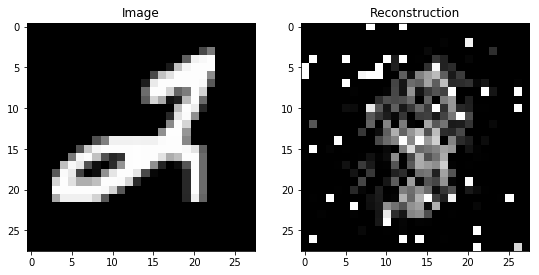

Step 14: Loss: 0.7967875003814697, Accuracy: 0.625
[ 0.         -0.          0.          0.          0.         -0.         -0.
 -0.         -0.         -0.         -0.          0.         -0.         -0.
  0.         -0.         -0.          0.          0.         -0.          0.
 -0.         -0.          0.         -0.         -0.          0.          0.
  0.         -0.         -0.         -0.          0.         -0.          0.
  0.         -0.          0.         -0.          0.          0.          0.
  0.          0.         -0.          0.          0.          0.          0.
  0.          0.          0.          0.         -0.          0.         -0.
 -0.         -0.         -0.          0.          0.          0.         -0.
 -0.          0.          0.         -0.         -0.         -0.         -0.
 -0.          0.          0.          0.          0.          0.          0.
  0.         -0.          0.          0.          0.          0.         -0.
 -0.         -0.         

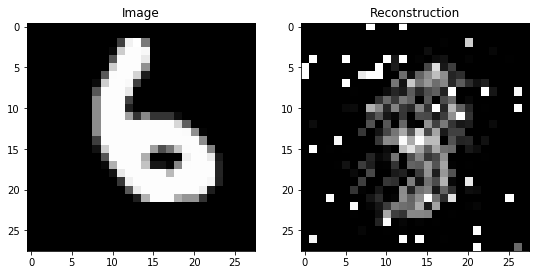

Step 15: Loss: 0.730692446231842, Accuracy: 0.6953125
[ 0.         -0.         -0.          0.          0.         -0.         -0.
 -0.          0.         -0.         -0.          0.          0.          0.
 -0.         -0.         -0.         -0.         -0.          0.          0.
 -0.          0.          0.         -0.          0.          0.          0.
  0.         -0.         -0.         -0.          0.          0.         -0.
  0.         -0.          0.         -0.         -0.          0.         -0.
 -0.          0.         -0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.         -0.
  0.         -0.         -0.          0.          0.          0.          0.
 -0.         -0.          0.          0.         -0.         -0.         -0.
  0.         -0.          0.          0.          0.         -0.         -0.
  0.         -0.         -0.         -0.00588681  0.02080928  0.03760717
  0.01298814  0.00354581 -

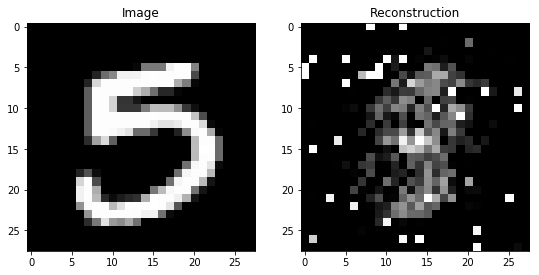

Step 16: Loss: 0.7490069270133972, Accuracy: 0.578125
[ 0.04784221 -0.04935002 -0.12437723  0.0795153   0.02569703 -0.15499365
 -0.23395981 -0.11791217 -0.13880461  0.03294821 -0.23659438  0.01190653
  0.13667184  0.11778806 -0.0700352  -0.12756164 -0.         -0.         -0.
  0.          0.          0.          0.          0.         -0.          0.
  0.         -0.          0.         -0.         -0.         -0.          0.
  0.         -0.         -0.         -0.          0.         -0.         -0.
 -0.         -0.          0.          0.         -0.         -0.          0.
  0.          0.         -0.          0.         -0.         -0.         -0.
 -0.         -0.          0.          0.         -0.          0.          0.
  0.          0.          0.          0.         -0.         -0.         -0.
  0.         -0.          0.          0.          0.          0.          0.
 -0.         -0.          0.         -0.         -0.         -0.         -0.
  0.          0.          0.  

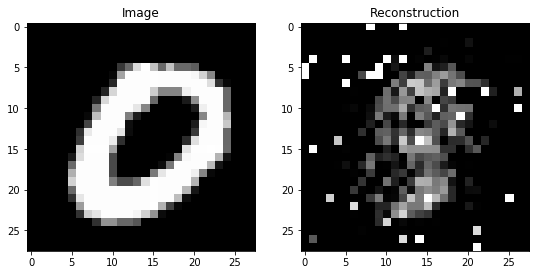

Step 17: Loss: 0.6688733100891113, Accuracy: 0.671875
[-0.         -0.         -0.         -0.         -0.          0.         -0.
 -0.          0.          0.          0.          0.         -0.          0.
 -0.         -0.          0.         -0.          0.          0.          0.
  0.          0.         -0.          0.          0.          0.         -0.
  0.          0.         -0.          0.         -0.          0.         -0.
 -0.         -0.          0.          0.         -0.         -0.         -0.
 -0.          0.         -0.         -0.          0.          0.          0.
  0.         -0.         -0.         -0.          0.         -0.         -0.
  0.         -0.          0.          0.          0.          0.          0.
  0.         -0.         -0.          0.          0.         -0.         -0.
 -0.          0.          0.          0.          0.         -0.         -0.
 -0.         -0.         -0.          0.         -0.          0.          0.
  0.          0.      

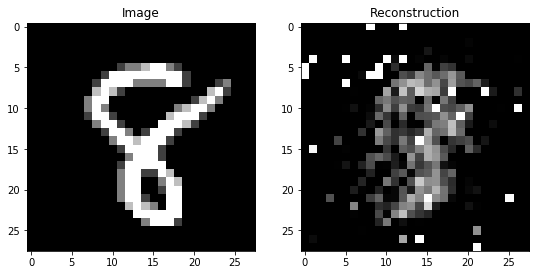

Step 18: Loss: 0.6906834244728088, Accuracy: 0.578125
[-0.          0.         -0.         -0.         -0.          0.         -0.
 -0.          0.         -0.          0.         -0.         -0.         -0.
 -0.          0.          0.         -0.          0.          0.          0.
  0.          0.         -0.          0.          0.         -0.         -0.
  0.          0.         -0.          0.         -0.          0.         -0.
 -0.          0.         -0.         -0.          0.          0.         -0.
 -0.          0.          0.         -0.         -0.          0.          0.
  0.          0.         -0.         -0.          0.         -0.         -0.
  0.         -0.          0.         -0.         -0.          0.          0.
 -0.          0.         -0.          0.          0.         -0.         -0.
 -0.          0.          0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.02119607 -0.06705745  0.02323925
  0.00420074  0.05286235  

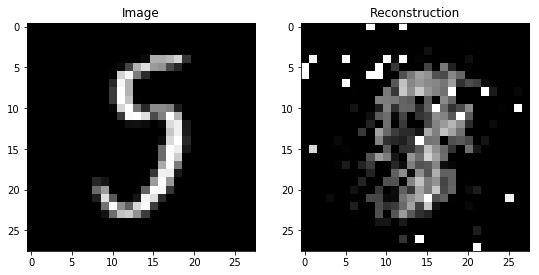

Step 19: Loss: 0.6428560018539429, Accuracy: 0.7265625
[-0.          0.         -0.          0.          0.         -0.          0.
 -0.         -0.         -0.          0.         -0.         -0.         -0.
 -0.         -0.          0.         -0.          0.         -0.          0.
  0.          0.         -0.          0.          0.         -0.         -0.
  0.          0.          0.          0.         -0.         -0.         -0.
 -0.          0.         -0.          0.          0.         -0.          0.
 -0.         -0.          0.         -0.         -0.          0.         -0.
 -0.          0.         -0.         -0.          0.         -0.          0.
 -0.         -0.          0.         -0.         -0.          0.         -0.
  0.         -0.         -0.         -0.          0.          0.          0.
 -0.          0.          0.         -0.         -0.         -0.          0.
 -0.         -0.          0.         -0.         -0.         -0.          0.
  0.          0.     

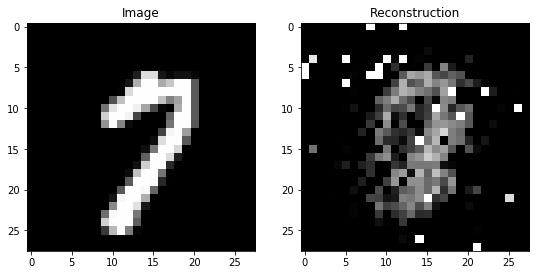

Step 20: Loss: 0.6192346215248108, Accuracy: 0.796875
[ 0.          0.         -0.          0.          0.         -0.          0.
 -0.         -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.          0.         -0.          0.
  0.         -0.         -0.          0.          0.         -0.         -0.
  0.          0.          0.          0.         -0.          0.          0.
 -0.          0.         -0.          0.          0.         -0.         -0.
 -0.         -0.          0.         -0.         -0.          0.         -0.
 -0.          0.         -0.         -0.         -0.         -0.          0.
 -0.         -0.          0.         -0.         -0.         -0.         -0.
 -0.          0.         -0.         -0.          0.         -0.          0.
 -0.          0.          0.         -0.         -0.          0.          0.
  0.          0.          0.          0.         -0.         -0.         -0.
  0.          0.      

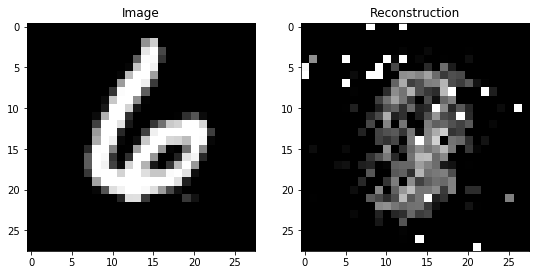

Step 21: Loss: 0.5795446634292603, Accuracy: 0.7421875
[ 0.          0.         -0.          0.          0.         -0.          0.
  0.          0.         -0.         -0.          0.         -0.         -0.
 -0.         -0.         -0.         -0.          0.         -0.          0.
  0.         -0.          0.          0.         -0.         -0.          0.
  0.         -0.          0.         -0.         -0.         -0.          0.
  0.          0.          0.          0.          0.         -0.         -0.
 -0.         -0.          0.          0.         -0.          0.          0.
  0.          0.         -0.         -0.          0.          0.          0.
  0.         -0.          0.         -0.         -0.          0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.          0.
 -0.         -0.          0.         -0.         -0.          0.         -0.
  0.          0.         -0.         -0.          0.          0.         -0.
 -0.         -0.     

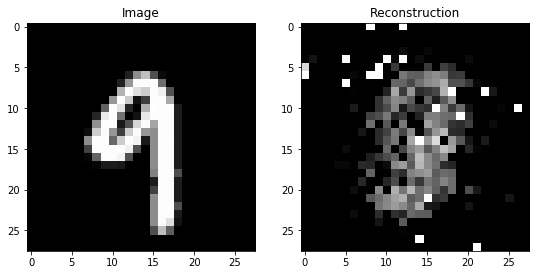

Step 22: Loss: 0.6478033065795898, Accuracy: 0.578125
[ 0.         -0.         -0.         -0.          0.         -0.          0.
 -0.         -0.          0.         -0.          0.          0.         -0.
 -0.         -0.         -0.25612485 -0.21529138  0.39222249 -0.06552795
 -0.00983193 -0.29760259 -0.21196632  0.27531359 -0.06860762  0.02939046
 -0.15976237  0.08407135  0.37376752 -0.16928221  0.01532628  0.06935295
  0.         -0.          0.          0.         -0.          0.          0.
  0.         -0.         -0.         -0.         -0.         -0.          0.
 -0.         -0.         -0.          0.          0.         -0.         -0.
  0.          0.          0.         -0.         -0.          0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.          0.
 -0.         -0.          0.          0.          0.          0.          0.
 -0.         -0.         -0.         -0.          0.         -0.         -0.
  0.         -0.         -0.      

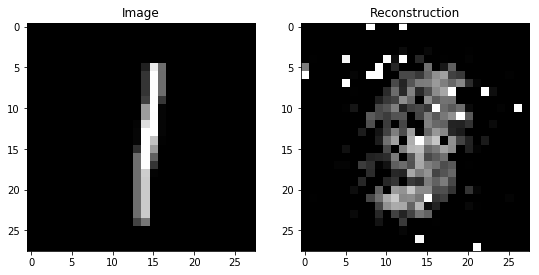

Step 23: Loss: 0.611034631729126, Accuracy: 0.7109375
[ 0.         -0.          0.          0.         -0.         -0.          0.
 -0.         -0.         -0.         -0.          0.          0.         -0.
  0.         -0.         -0.          0.          0.         -0.         -0.
  0.         -0.          0.         -0.         -0.          0.          0.
 -0.         -0.          0.         -0.          0.          0.          0.
 -0.         -0.          0.          0.         -0.          0.         -0.
 -0.         -0.         -0.          0.          0.         -0.
  0.18333781  0.22965059 -0.05965271  0.03992815 -0.10861432  0.27170983
  0.19930102 -0.07981756  0.06266941  0.00559325  0.02539538 -0.00677726
  0.01935329  0.10325252 -0.00829052 -0.21111268 -0.          0.          0.
  0.         -0.          0.         -0.          0.          0.          0.
 -0.          0.         -0.          0.          0.          0.          0.
  0.          0.         -0.          0.  

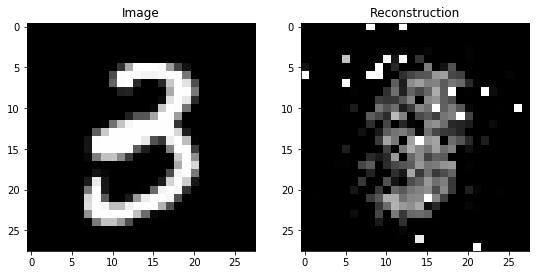

Step 24: Loss: 0.594494104385376, Accuracy: 0.7578125
[-0.          0.          0.         -0.         -0.         -0.          0.
  0.          0.          0.         -0.         -0.         -0.          0.
  0.         -0.         -0.          0.          0.          0.         -0.
 -0.         -0.          0.         -0.         -0.          0.          0.
 -0.         -0.          0.         -0.          0.02705497  0.03779987
  0.11054447 -0.07844152 -0.03555002 -0.0058231  -0.02483841 -0.02975527
 -0.02232085 -0.04872389 -0.06178721 -0.0095812  -0.059551    0.01227051
  0.04030957 -0.07908093  0.          0.         -0.          0.          0.
  0.          0.         -0.          0.          0.         -0.          0.
 -0.          0.          0.         -0.          0.          0.          0.
  0.         -0.          0.          0.          0.          0.          0.
 -0.          0.         -0.          0.          0.          0.         -0.
  0.          0.          0.      

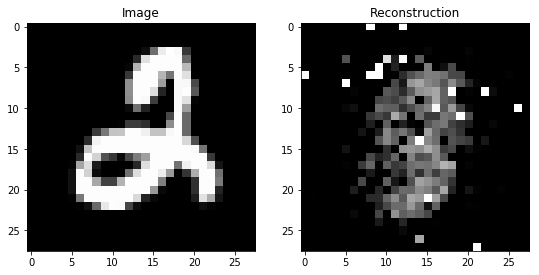

Step 25: Loss: 0.5784629583358765, Accuracy: 0.7265625
[ 0.         -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.          0.         -0.          0.          0.          0.
  0.         -0.          0.          0.         -0.         -0.         -0.
 -0.         -0.          0.         -0.         -0.          0.          0.
 -0.          0.         -0.          0.          0.          0.          0.
  0.         -0.         -0.         -0.          0.          0.         -0.
 -0.         -0.         -0.         -0.          0.         -0.          0.
  0.         -0.          0.          0.          0.          0.          0.
  0.          0.         -0.         -0.         -0.         -0.         -0.
  0.          0.          0.         -0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.         -0.
  0.          0.          0.          0.          0.          0.          0.
 -0.          0.     

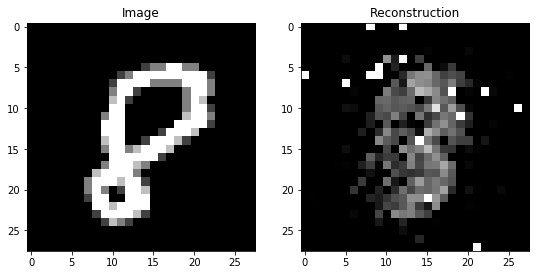

Step 26: Loss: 0.5659498572349548, Accuracy: 0.7265625
[ 0.         -0.          0.         -0.         -0.          0.          0.
  0.          0.          0.         -0.         -0.         -0.          0.
  0.          0.         -0.          0.          0.          0.          0.
 -0.         -0.          0.         -0.          0.         -0.         -0.
 -0.         -0.         -0.         -0.          0.          0.          0.
  0.         -0.          0.         -0.          0.          0.          0.
  0.         -0.          0.         -0.          0.         -0.          0.
  0.         -0.          0.          0.          0.          0.         -0.
  0.         -0.         -0.          0.          0.          0.          0.
 -0.          0.          0.         -0.          0.          0.         -0.
  0.          0.         -0.          0.          0.          0.         -0.
  0.          0.         -0.          0.          0.          0.          0.
  0.          0.     

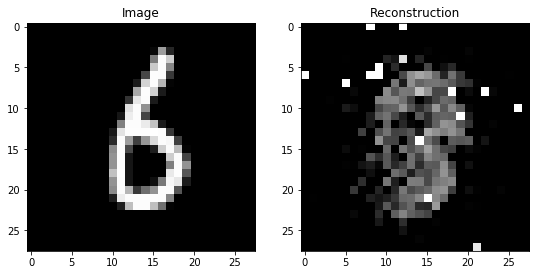

Step 27: Loss: 0.5531037449836731, Accuracy: 0.7421875
[-0.         -0.          0.          0.         -0.          0.         -0.
  0.         -0.          0.          0.         -0.          0.          0.
  0.          0.         -0.         -0.          0.          0.          0.
 -0.         -0.          0.         -0.          0.         -0.          0.
  0.         -0.          0.          0.          0.          0.          0.
  0.         -0.          0.         -0.         -0.         -0.         -0.
 -0.          0.         -0.         -0.          0.         -0.          0.
 -0.         -0.          0.          0.          0.          0.         -0.
 -0.          0.         -0.          0.          0.          0.          0.
  0.         -0.          0.         -0.          0.          0.         -0.
 -0.          0.          0.          0.          0.          0.          0.
 -0.         -0.          0.         -0.         -0.          0.         -0.
 -0.          0.     

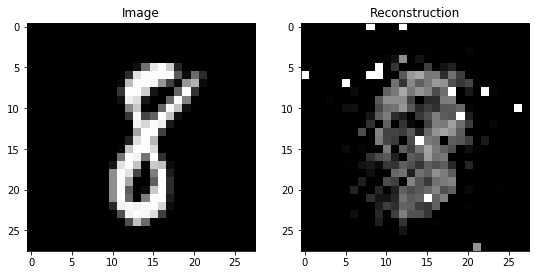

Step 28: Loss: 0.581397533416748, Accuracy: 0.6953125
[ 0.          0.          0.          0.         -0.          0.         -0.
  0.          0.          0.          0.         -0.          0.          0.
  0.          0.         -0.         -0.          0.         -0.          0.
 -0.         -0.          0.         -0.          0.         -0.         -0.
  0.         -0.         -0.          0.          0.          0.          0.
  0.         -0.         -0.         -0.         -0.          0.          0.
 -0.          0.         -0.         -0.          0.         -0.         -0.
 -0.          0.          0.          0.         -0.          0.         -0.
 -0.         -0.         -0.          0.          0.          0.          0.
 -0.         -0.         -0.          0.          0.         -0.         -0.
 -0.          0.         -0.          0.          0.          0.         -0.
  0.         -0.          0.         -0.         -0.          0.          0.
 -0.          0.      

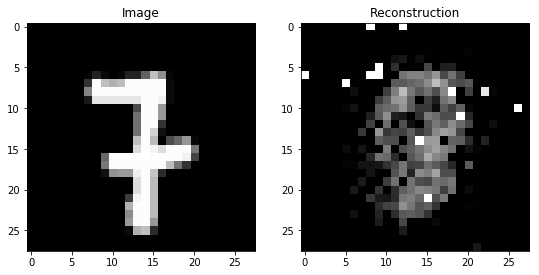

Step 29: Loss: 0.5307779312133789, Accuracy: 0.765625
[ 0.          0.         -0.          0.          0.          0.         -0.
 -0.          0.          0.          0.         -0.         -0.          0.
 -0.         -0.          0.          0.         -0.          0.          0.
 -0.          0.         -0.         -0.         -0.          0.         -0.
 -0.         -0.         -0.         -0.         -0.          0.          0.
 -0.         -0.          0.         -0.         -0.         -0.         -0.
 -0.          0.          0.         -0.          0.         -0.         -0.
 -0.         -0.          0.          0.         -0.          0.         -0.
 -0.         -0.         -0.          0.          0.          0.         -0.
  0.         -0.09955397 -0.01280994 -0.03732145  0.15299205 -0.15636791
  0.03401648 -0.0484366   0.02736958  0.06354069 -0.00415002  0.10465673
  0.0712584  -0.11445903  0.05465856 -0.01996623  0.052274   -0.         -0.
  0.         -0.          0.  

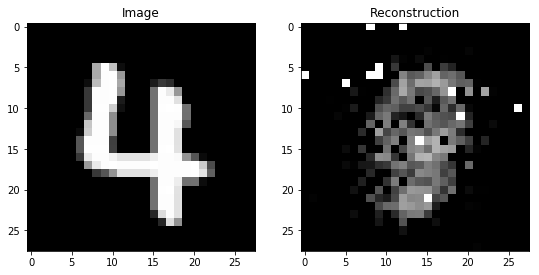

Step 30: Loss: 0.5160658359527588, Accuracy: 0.8125
[ 0.          0.         -0.          0.          0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.          0.
 -0.         -0.          0.          0.         -0.         -0.          0.
 -0.         -0.         -0.         -0.          0.          0.         -0.
 -0.          0.         -0.          0.         -0.          0.         -0.
 -0.         -0.         -0.         -0.         -0.          0.         -0.
 -0.          0.         -0.         -0.         -0.         -0.          0.
  0.          0.         -0.         -0.         -0.         -0.         -0.
 -0.          0.         -0.          0.          0.          0.          0.
  0.          0.         -0.          0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.          0.         -0.          0.
 -0.         -0.          0.          0.         -0.          0.          0.
  0.          0.        

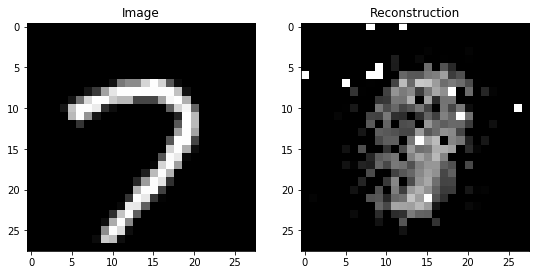

Step 31: Loss: 0.4882317781448364, Accuracy: 0.7578125
[ 0.          0.         -0.          0.          0.         -0.         -0.
 -0.         -0.         -0.          0.          0.         -0.         -0.
 -0.         -0.          0.          0.         -0.          0.         -0.
 -0.          0.         -0.         -0.          0.         -0.          0.
  0.          0.         -0.         -0.         -0.         -0.         -0.
 -0.          0.          0.         -0.          0.          0.         -0.
 -0.          0.         -0.          0.         -0.         -0.          0.
  0.         -0.          0.          0.         -0.          0.          0.
  0.         -0.         -0.         -0.          0.          0.         -0.
 -0.         -0.         -0.         -0.          0.         -0.          0.
  0.         -0.          0.         -0.          0.          0.         -0.
  0.         -0.          0.          0.         -0.          0.         -0.
  0.         -0.     

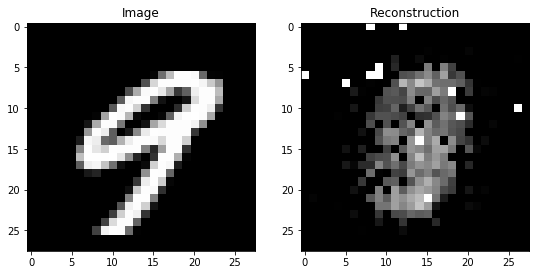

Step 32: Loss: 0.5204511880874634, Accuracy: 0.7109375
[ 0.          0.         -0.         -0.         -0.          0.         -0.
  0.          0.         -0.          0.          0.         -0.          0.
  0.          0.         -0.         -0.         -0.         -0.          0.
 -0.         -0.         -0.         -0.          0.         -0.          0.
  0.          0.          0.         -0.          0.          0.         -0.
 -0.         -0.          0.          0.          0.          0.         -0.
 -0.          0.         -0.         -0.         -0.          0.          0.
  0.         -0.         -0.         -0.         -0.          0.         -0.
  0.         -0.         -0.          0.          0.          0.          0.
 -0.          0.         -0.         -0.          0.         -0.          0.
  0.         -0.         -0.         -0.          0.          0.         -0.
 -0.         -0.          0.          0.         -0.          0.          0.
  0.          0.     

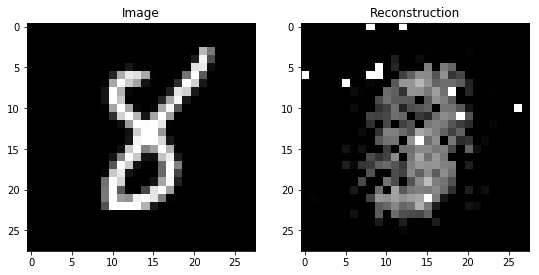

Step 33: Loss: 0.5049816370010376, Accuracy: 0.8203125
[ 0.         -0.         -0.          0.         -0.         -0.         -0.
 -0.          0.         -0.          0.          0.         -0.         -0.
 -0.          0.         -0.         -0.          0.         -0.          0.
 -0.         -0.          0.         -0.          0.         -0.          0.
  0.         -0.          0.          0.         -0.         -0.         -0.
 -0.          0.         -0.          0.          0.          0.         -0.
 -0.          0.         -0.          0.          0.          0.          0.
  0.         -0.         -0.         -0.          0.          0.         -0.
  0.          0.          0.         -0.          0.         -0.          0.
 -0.          0.          0.         -0.         -0.         -0.          0.
  0.         -0.         -0.         -0.          0.          0.          0.
 -0.         -0.         -0.          0.         -0.         -0.         -0.
  0.         -0.     

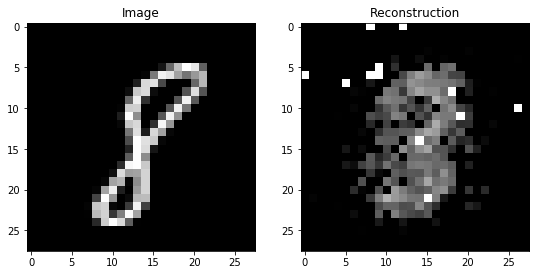

Step 34: Loss: 0.49535834789276123, Accuracy: 0.75
[ 0.          0.         -0.          0.         -0.          0.         -0.
  0.         -0.         -0.         -0.          0.         -0.         -0.
  0.          0.         -0.         -0.          0.          0.          0.
  0.          0.          0.          0.         -0.         -0.          0.
  0.          0.          0.         -0.          0.         -0.         -0.
  0.          0.          0.          0.          0.         -0.          0.
 -0.         -0.          0.         -0.         -0.          0.          0.
  0.         -0.         -0.         -0.          0.          0.         -0.
  0.          0.          0.         -0.          0.          0.          0.
 -0.          0.         -0.         -0.          0.         -0.          0.
  0.         -0.         -0.         -0.          0.          0.         -0.
  0.         -0.         -0.          0.         -0.          0.          0.
  0.         -0.         

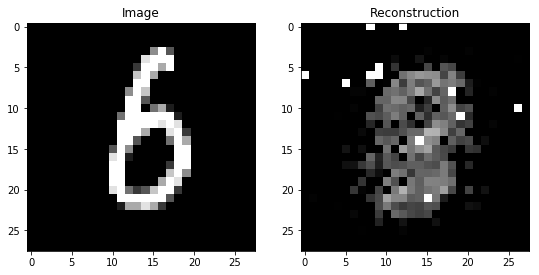

Step 35: Loss: 0.45882561802864075, Accuracy: 0.7890625
[ 0.          0.          0.         -0.         -0.          0.         -0.
  0.          0.         -0.          0.          0.         -0.         -0.
  0.          0.          0.          0.         -0.         -0.         -0.
  0.          0.          0.          0.         -0.         -0.         -0.
  0.          0.         -0.         -0.          0.          0.         -0.
 -0.         -0.          0.          0.          0.         -0.         -0.
 -0.          0.         -0.         -0.         -0.          0.          0.
  0.          0.         -0.         -0.         -0.         -0.          0.
  0.          0.          0.         -0.          0.          0.         -0.
 -0.          0.         -0.         -0.          0.         -0.          0.
 -0.          0.          0.          0.          0.          0.         -0.
  0.          0.          0.         -0.          0.          0.          0.
  0.         -0.    

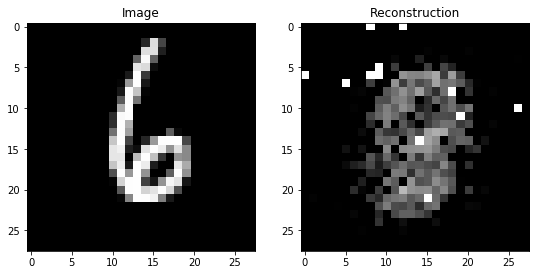

Step 36: Loss: 0.4810332953929901, Accuracy: 0.7890625
[ 0.         -0.         -0.          0.          0.         -0.         -0.
 -0.         -0.         -0.         -0.          0.          0.         -0.
 -0.         -0.          0.          0.         -0.          0.         -0.
  0.          0.         -0.          0.         -0.          0.         -0.
 -0.          0.         -0.         -0.          0.          0.         -0.
 -0.         -0.         -0.          0.         -0.         -0.         -0.
 -0.          0.          0.          0.          0.          0.          0.
  0.         -0.         -0.         -0.          0.         -0.          0.
  0.          0.          0.         -0.          0.          0.          0.
 -0.         -0.         -0.         -0.          0.          0.          0.
 -0.          0.          0.          0.          0.          0.         -0.
  0.          0.          0.         -0.02627024 -0.07021777  0.01927938
  0.06856225  0.02165253 

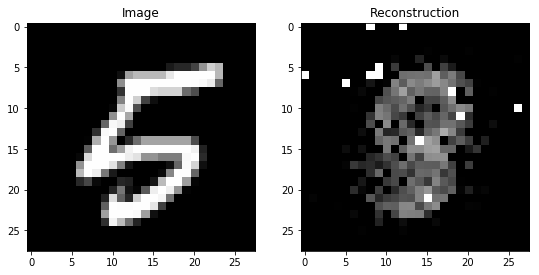

Step 37: Loss: 0.4481334984302521, Accuracy: 0.8203125
[-0.          0.          0.         -0.         -0.          0.         -0.
 -0.         -0.         -0.          0.          0.         -0.         -0.
  0.         -0.          0.         -0.          0.         -0.          0.
  0.         -0.          0.          0.         -0.          0.          0.
  0.          0.          0.          0.         -0.          0.         -0.
  0.          0.          0.          0.          0.         -0.         -0.
  0.         -0.         -0.          0.          0.          0.         -0.
 -0.         -0.         -0.         -0.          0.         -0.          0.
 -0.         -0.          0.         -0.         -0.         -0.         -0.
  0.          0.          0.         -0.          0.          0.          0.
 -0.          0.          0.          0.         -0.          0.         -0.
  0.         -0.          0.         -0.         -0.          0.          0.
  0.          0.     

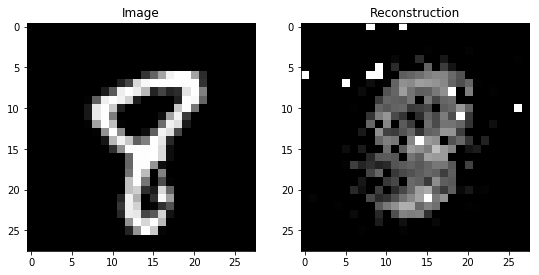

Step 38: Loss: 0.45240306854248047, Accuracy: 0.828125
[ 0.         -0.          0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.          0.          0.         -0.
  0.         -0.          0.          0.         -0.          0.         -0.
  0.         -0.         -0.          0.         -0.          0.          0.
 -0.          0.         -0.         -0.          0.          0.         -0.
 -0.         -0.          0.          0.         -0.         -0.          0.
 -0.         -0.         -0.         -0.         -0.          0.          0.
  0.         -0.          0.         -0.          0.          0.         -0.
  0.         -0.          0.          0.          0.          0.          0.
 -0.         -0.          0.         -0.          0.         -0.          0.
 -0.          0.          0.          0.         -0.          0.         -0.
  0.         -0.         -0.         -0.          0.          0.          0.
  0.         -0.     

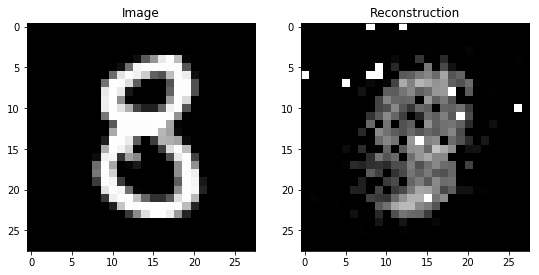

Step 39: Loss: 0.4169517755508423, Accuracy: 0.859375
[-0.         -0.          0.         -0.         -0.          0.          0.
  0.          0.          0.          0.          0.         -0.         -0.
  0.          0.         -0.23643458 -0.32177255  0.38584667 -0.09488373
 -0.01096775 -0.31130877 -0.22831027  0.26052088 -0.03418509  0.10001796
 -0.18634591  0.06375386  0.3655645  -0.1987275   0.01047566  0.05150856
  0.         -0.         -0.          0.         -0.         -0.          0.
  0.         -0.          0.          0.         -0.          0.          0.
  0.          0.         -0.          0.         -0.         -0.         -0.
  0.          0.         -0.          0.         -0.          0.         -0.
 -0.         -0.         -0.         -0.         -0.          0.          0.
 -0.          0.          0.          0.          0.          0.          0.
 -0.          0.          0.         -0.          0.         -0.         -0.
  0.          0.          0.      

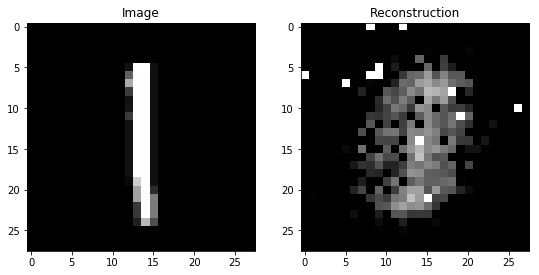

Step 40: Loss: 0.48280060291290283, Accuracy: 0.7578125
[ 0.         -0.          0.         -0.         -0.         -0.          0.
  0.          0.          0.         -0.         -0.          0.         -0.
  0.          0.          0.         -0.          0.         -0.         -0.
  0.         -0.         -0.         -0.          0.          0.          0.
 -0.         -0.         -0.          0.         -0.         -0.          0.
  0.         -0.          0.          0.         -0.          0.          0.
  0.         -0.          0.          0.          0.          0.         -0.
 -0.          0.          0.          0.          0.         -0.          0.
 -0.         -0.          0.          0.         -0.         -0.          0.
 -0.         -0.         -0.         -0.          0.         -0.          0.
 -0.          0.          0.          0.          0.          0.         -0.
  0.          0.          0.          0.         -0.         -0.          0.
  0.          0.    

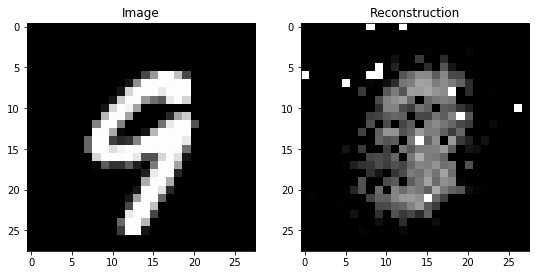

Step 41: Loss: 0.46589770913124084, Accuracy: 0.8125
[ 0.         -0.          0.          0.         -0.         -0.          0.
 -0.         -0.          0.         -0.         -0.          0.         -0.
  0.          0.         -0.         -0.          0.          0.         -0.
 -0.         -0.          0.         -0.          0.         -0.         -0.
  0.         -0.          0.          0.         -0.         -0.          0.
  0.         -0.          0.          0.         -0.          0.         -0.
  0.          0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.          0.          0.          0.          0.          0.
 -0.         -0.          0.          0.         -0.         -0.         -0.
  0.         -0.          0.         -0.          0.         -0.         -0.
 -0.         -0.          0.         -0.         -0.         -0.          0.
  0.          0.          0.          0.         -0.          0.         -0.
  0.          0.       

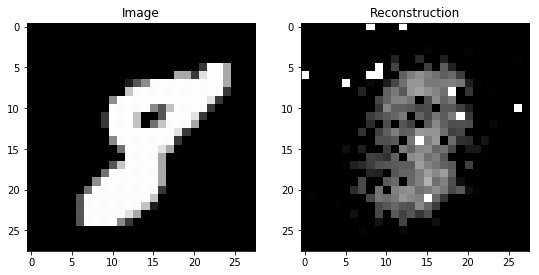

Step 42: Loss: 0.45660144090652466, Accuracy: 0.8359375
[ 0.          0.         -0.          0.          0.         -0.          0.
 -0.         -0.          0.         -0.         -0.          0.         -0.
 -0.         -0.         -0.         -0.          0.         -0.         -0.
 -0.         -0.          0.         -0.          0.         -0.         -0.
  0.         -0.         -0.          0.          0.01713455  0.19704758
  0.24491748 -0.17815179 -0.13310312  0.1055854  -0.09925846 -0.03510379
 -0.09047156 -0.25032225 -0.3684687   0.13977632 -0.10994177 -0.065829
  0.02393918 -0.0897721  -0.         -0.          0.         -0.          0.
 -0.         -0.          0.         -0.         -0.         -0.          0.
 -0.         -0.          0.          0.         -0.         -0.         -0.
  0.         -0.          0.         -0.          0.          0.         -0.
 -0.          0.         -0.          0.         -0.          0.          0.
 -0.         -0.         -0.      

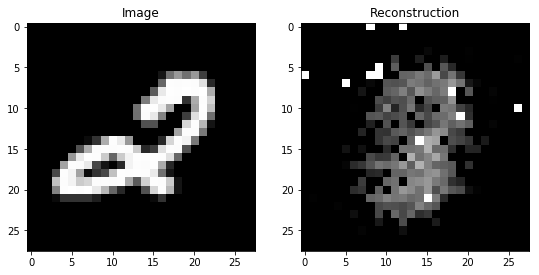

Step 43: Loss: 0.44994378089904785, Accuracy: 0.8359375
[-0.          0.          0.          0.         -0.         -0.          0.
 -0.         -0.          0.          0.         -0.         -0.          0.
 -0.         -0.         -0.         -0.          0.         -0.         -0.
 -0.         -0.          0.          0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.          0.         -0.
  0.          0.          0.         -0.          0.         -0.          0.
 -0.         -0.         -0.         -0.         -0.         -0.
  0.19174726  0.28491026 -0.10625375  0.07750272 -0.08844579  0.25511187
  0.18992721 -0.21318607  0.08855539 -0.00988948  0.01407611  0.09586495
  0.10464869  0.19481349  0.02043338 -0.25323284  0.          0.         -0.
  0.         -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.          0.         -0.          0.         -0.         -0.
 -0.          0.          0.          0.

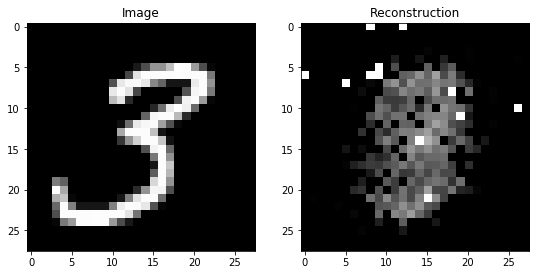

Step 44: Loss: 0.47193360328674316, Accuracy: 0.7890625
[-0.         -0.          0.         -0.          0.          0.          0.
  0.          0.          0.          0.         -0.         -0.          0.
  0.          0.         -0.          0.         -0.         -0.         -0.
 -0.          0.          0.          0.         -0.          0.         -0.
  0.         -0.         -0.         -0.          0.         -0.          0.
  0.          0.          0.         -0.          0.          0.          0.
  0.          0.          0.          0.         -0.         -0.
  0.20263924  0.27837732 -0.0690689  -0.0118361  -0.03078035  0.201619
  0.24831778 -0.21024224  0.09357271 -0.06562438  0.00501549  0.00501339
  0.10216108  0.17709865 -0.03999973 -0.32128748  0.         -0.          0.
 -0.          0.         -0.          0.         -0.         -0.         -0.
 -0.         -0.          0.         -0.          0.         -0.         -0.
 -0.          0.          0.          0.  

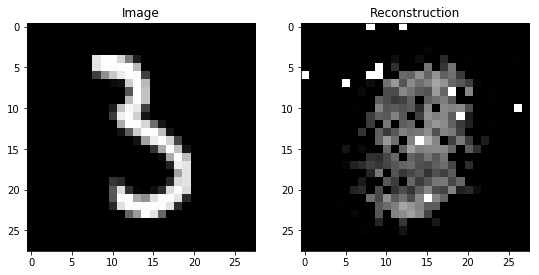

Step 45: Loss: 0.42000001668930054, Accuracy: 0.8046875
[-0.          0.          0.         -0.         -0.          0.          0.
  0.          0.          0.          0.          0.         -0.          0.
  0.          0.          0.          0.         -0.         -0.          0.
  0.          0.         -0.         -0.         -0.          0.          0.
 -0.          0.         -0.         -0.         -0.         -0.          0.
 -0.          0.         -0.         -0.          0.          0.         -0.
 -0.          0.         -0.          0.         -0.         -0.          0.
  0.         -0.          0.          0.         -0.          0.         -0.
  0.         -0.          0.          0.          0.          0.         -0.
 -0.         -0.         -0.         -0.          0.         -0.          0.
 -0.          0.          0.          0.          0.          0.         -0.
  0.          0.          0.         -0.         -0.          0.          0.
 -0.          0.    

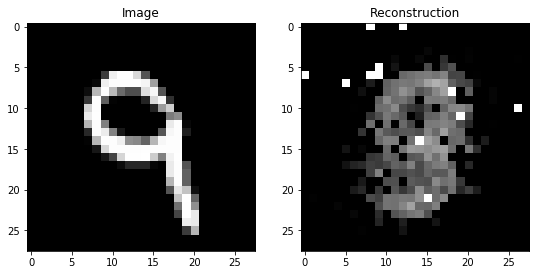

Step 46: Loss: 0.42823073267936707, Accuracy: 0.828125
[-0.          0.         -0.         -0.          0.         -0.          0.
  0.         -0.         -0.         -0.          0.          0.          0.
 -0.         -0.          0.          0.         -0.         -0.          0.
 -0.          0.         -0.         -0.         -0.          0.         -0.
 -0.          0.         -0.         -0.          0.0134063   0.06666032
  0.06213563 -0.07336182 -0.00452914 -0.02456066 -0.01947097 -0.01769611
 -0.01271477 -0.08756168 -0.15816061  0.05089178 -0.05665747 -0.02275656
 -0.0152896  -0.01391057  0.          0.         -0.         -0.          0.
 -0.         -0.          0.          0.         -0.         -0.          0.
  0.          0.         -0.          0.         -0.         -0.         -0.
  0.         -0.          0.         -0.          0.          0.          0.
 -0.          0.         -0.          0.         -0.          0.         -0.
  0.          0.          0.     

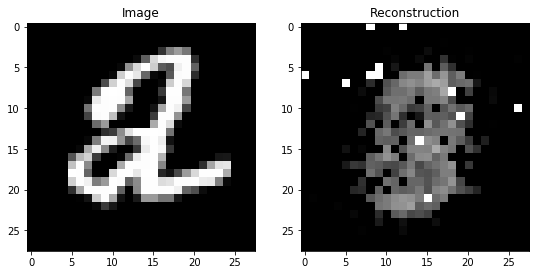

Step 47: Loss: 0.43097591400146484, Accuracy: 0.84375
[ 0.          0.         -0.          0.          0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.          0.          0.
 -0.         -0.         -0.         -0.          0.         -0.          0.
 -0.         -0.          0.         -0.          0.         -0.          0.
  0.         -0.          0.          0.          0.          0.          0.
 -0.         -0.         -0.         -0.         -0.          0.         -0.
 -0.          0.         -0.          0.         -0.         -0.          0.
 -0.         -0.          0.         -0.         -0.          0.          0.
  0.         -0.         -0.          0.         -0.         -0.         -0.
 -0.          0.         -0.         -0.         -0.          0.         -0.
 -0.          0.         -0.         -0.         -0.         -0.          0.
  0.          0.         -0.         -0.0372312  -0.03192803 -0.00803778
 -0.00878477  0.0183128  -

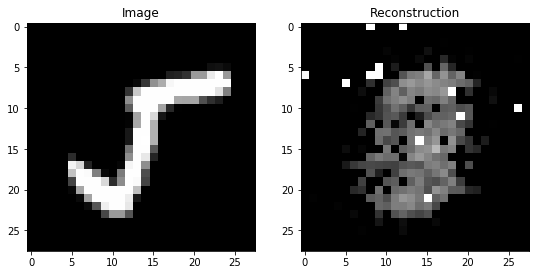

Step 48: Loss: 0.43640583753585815, Accuracy: 0.828125
[ 0.         -0.         -0.          0.          0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.          0.         -0.
 -0.         -0.          0.         -0.         -0.          0.          0.
  0.          0.         -0.          0.         -0.         -0.          0.
 -0.          0.          0.         -0.         -0.         -0.         -0.
 -0.          0.         -0.         -0.          0.         -0.         -0.
 -0.          0.          0.         -0.          0.          0.          0.
  0.         -0.          0.         -0.          0.          0.         -0.
  0.         -0.         -0.          0.          0.          0.          0.
 -0.         -0.         -0.         -0.          0.         -0.          0.
 -0.          0.          0.          0.          0.          0.         -0.
  0.          0.          0.          0.00858726  0.0219183   0.10623853
  0.02802677  0.04180369 

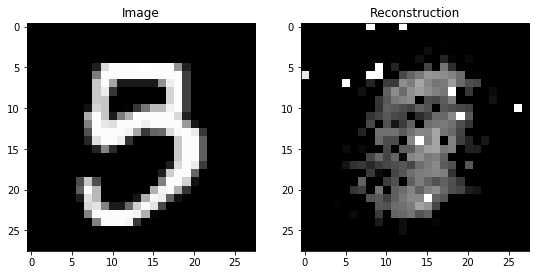

Step 49: Loss: 0.4591202139854431, Accuracy: 0.8359375
[ 0.         -0.          0.         -0.         -0.         -0.         -0.
 -0.          0.         -0.          0.         -0.          0.         -0.
  0.          0.         -0.         -0.         -0.          0.          0.
 -0.          0.         -0.          0.         -0.         -0.          0.
  0.         -0.         -0.         -0.          0.          0.         -0.
 -0.          0.          0.          0.         -0.         -0.         -0.
 -0.          0.         -0.         -0.         -0.          0.
  0.18887816  0.36498311 -0.13849665  0.02565738 -0.05123228  0.32069254
  0.23926468 -0.2441339   0.11707407 -0.08217234 -0.01859173 -0.00981363
  0.0898007   0.25113368 -0.01177339 -0.37171352 -0.          0.          0.
 -0.          0.          0.         -0.          0.         -0.          0.
  0.          0.         -0.         -0.         -0.         -0.          0.
 -0.          0.          0.          0. 

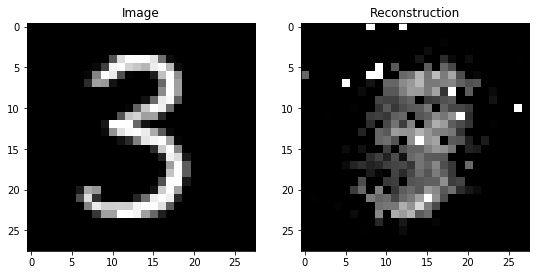

Step 50: Loss: 0.4191802740097046, Accuracy: 0.828125
[ 0.08100962 -0.06367591 -0.16877079  0.11971329  0.11034686 -0.34624109
 -0.06870151 -0.24134129 -0.25859547 -0.05738401 -0.37430698 -0.13153435
  0.17803967 -0.0189687  -0.16839239 -0.24208219 -0.         -0.         -0.
  0.         -0.         -0.          0.         -0.         -0.          0.
  0.          0.          0.          0.          0.          0.          0.
 -0.         -0.          0.         -0.          0.          0.         -0.
 -0.         -0.          0.          0.          0.          0.          0.
  0.         -0.         -0.         -0.          0.         -0.         -0.
 -0.          0.         -0.          0.         -0.         -0.         -0.
 -0.         -0.          0.         -0.         -0.          0.          0.
  0.         -0.         -0.          0.         -0.          0.          0.
  0.         -0.          0.         -0.          0.          0.         -0.
  0.         -0.          0.  

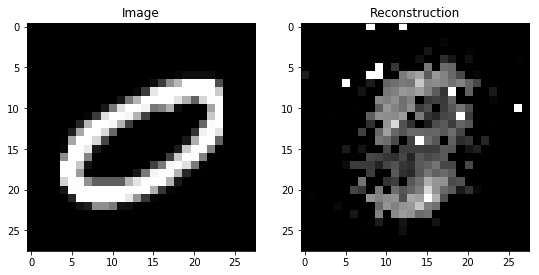

Step 51: Loss: 0.36339694261550903, Accuracy: 0.875
[ 0.         -0.         -0.          0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.          0.         -0.
  0.         -0.          0.         -0.         -0.          0.          0.
 -0.         -0.         -0.          0.          0.          0.          0.
  0.         -0.          0.         -0.          0.          0.          0.
 -0.         -0.          0.         -0.         -0.         -0.         -0.
 -0.          0.         -0.         -0.          0.          0.
  0.16378823  0.2976959  -0.15452275 -0.00483111 -0.05950928  0.30245385
  0.19137049 -0.19954368  0.11402886 -0.10037526 -0.06480865  0.01824195
  0.04249959  0.23924012 -0.00850483 -0.27562776  0.          0.          0.
 -0.          0.         -0.          0.         -0.         -0.         -0.
  0.         -0.          0.         -0.          0.         -0.          0.
  0.          0.         -0.         -0.    

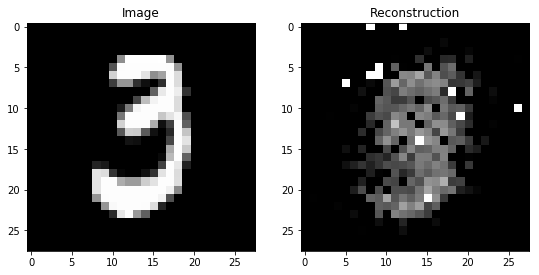

Step 52: Loss: 0.4631887674331665, Accuracy: 0.75
[ 0.          0.          0.          0.         -0.          0.         -0.
  0.          0.          0.          0.          0.         -0.         -0.
  0.          0.          0.          0.         -0.          0.         -0.
 -0.         -0.         -0.          0.          0.          0.         -0.
 -0.          0.          0.         -0.         -0.          0.         -0.
 -0.          0.         -0.          0.         -0.         -0.          0.
  0.          0.         -0.          0.          0.          0.          0.
  0.         -0.          0.         -0.          0.         -0.         -0.
  0.          0.          0.          0.          0.          0.          0.
 -0.         -0.10357484 -0.03811841 -0.03574737  0.2690576  -0.15600303
  0.18429916 -0.10055604  0.14318706  0.14073493  0.02130395  0.15964051
  0.21972959 -0.21682532  0.07668441 -0.01359739  0.11093236  0.         -0.
  0.          0.          0.      

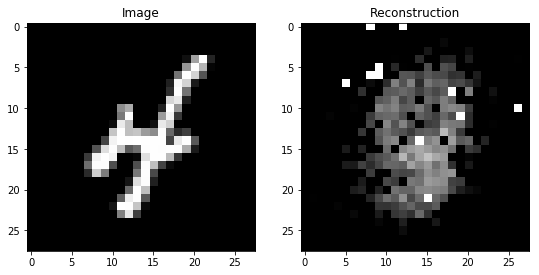

Step 53: Loss: 0.4160338342189789, Accuracy: 0.8046875
[ 0.08180871 -0.06571323 -0.11336053  0.14722341  0.14351915 -0.33239642
 -0.06943208 -0.2551344  -0.33577999 -0.07770795 -0.36692074 -0.10501923
  0.17962527  0.04239334 -0.18475376 -0.31049114  0.          0.         -0.
 -0.          0.          0.          0.         -0.         -0.          0.
  0.         -0.         -0.          0.          0.         -0.          0.
  0.         -0.          0.         -0.          0.         -0.         -0.
 -0.          0.         -0.         -0.         -0.         -0.          0.
  0.         -0.         -0.          0.          0.          0.         -0.
 -0.          0.          0.          0.          0.         -0.         -0.
 -0.         -0.          0.          0.          0.          0.         -0.
  0.         -0.          0.         -0.          0.         -0.         -0.
 -0.          0.          0.          0.         -0.          0.          0.
  0.          0.         -0. 

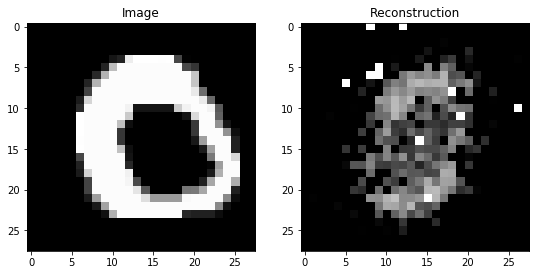

Step 54: Loss: 0.37597543001174927, Accuracy: 0.84375
[-0.          0.          0.         -0.          0.          0.         -0.
  0.          0.          0.          0.          0.         -0.          0.
  0.          0.          0.          0.         -0.          0.         -0.
  0.          0.          0.         -0.         -0.         -0.         -0.
 -0.         -0.          0.         -0.         -0.          0.          0.
 -0.         -0.          0.         -0.          0.          0.         -0.
 -0.          0.         -0.         -0.          0.          0.         -0.
 -0.          0.          0.         -0.         -0.         -0.          0.
 -0.          0.          0.         -0.         -0.         -0.          0.
  0.         -0.1627917  -0.04361989 -0.07283675  0.30604261 -0.20983711
  0.26346594 -0.02377315  0.15913275  0.26054677 -0.01249742  0.17457782
  0.25465748 -0.20352572  0.16017212  0.02385766  0.15470162 -0.         -0.
 -0.         -0.          0.  

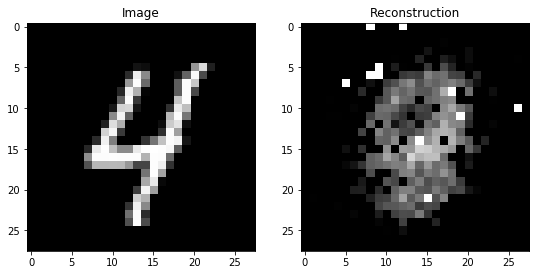

Step 55: Loss: 0.42867833375930786, Accuracy: 0.828125
[-0.         -0.         -0.          0.          0.         -0.         -0.
 -0.         -0.          0.         -0.          0.          0.          0.
 -0.         -0.          0.          0.         -0.          0.         -0.
  0.          0.         -0.         -0.         -0.          0.         -0.
 -0.         -0.          0.         -0.         -0.         -0.         -0.
  0.          0.          0.          0.         -0.          0.          0.
  0.         -0.          0.          0.          0.         -0.          0.
  0.          0.         -0.         -0.          0.          0.         -0.
 -0.         -0.         -0.          0.          0.          0.          0.
 -0.         -0.         -0.         -0.          0.         -0.          0.
 -0.          0.          0.          0.          0.          0.         -0.
  0.          0.          0.         -0.03324329 -0.10700128  0.1161124
  0.10311645  0.11303464  

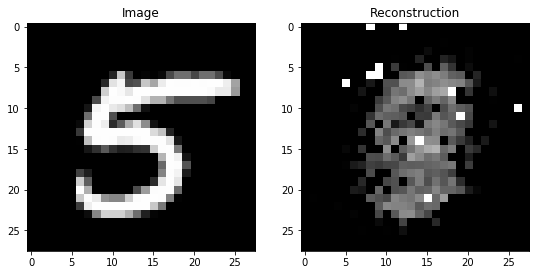

Step 56: Loss: 0.3600284457206726, Accuracy: 0.8828125
[-0.         -0.         -0.         -0.          0.          0.         -0.
 -0.         -0.          0.          0.          0.          0.          0.
 -0.          0.         -0.29756388 -0.24190637  0.40449706 -0.0961735
  0.03481263 -0.30781284 -0.17678231  0.21271919 -0.1245141   0.09242854
 -0.22446083  0.05446008  0.42593414 -0.13246645 -0.00498507  0.08442718
 -0.          0.          0.          0.         -0.         -0.         -0.
 -0.         -0.          0.         -0.          0.         -0.         -0.
 -0.          0.          0.          0.          0.          0.         -0.
  0.          0.         -0.         -0.         -0.          0.          0.
 -0.          0.         -0.          0.         -0.          0.          0.
 -0.          0.         -0.          0.          0.         -0.         -0.
  0.         -0.          0.          0.          0.          0.         -0.
 -0.         -0.         -0.      

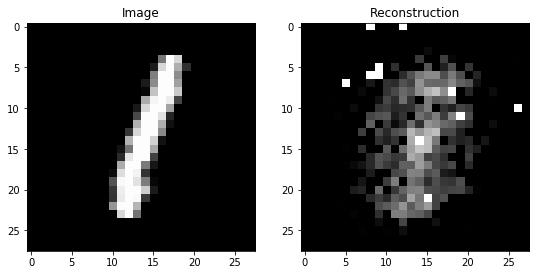

Step 57: Loss: 0.3880615830421448, Accuracy: 0.84375
[-0.          0.          0.          0.          0.          0.         -0.
 -0.         -0.         -0.         -0.          0.          0.          0.
  0.         -0.         -0.          0.          0.          0.          0.
  0.          0.          0.          0.         -0.         -0.         -0.
 -0.          0.         -0.         -0.          0.08448788  0.28336158
  0.16896057 -0.33614141 -0.17162482 -0.02130521 -0.11780466  0.01813434
 -0.03123172 -0.28392106 -0.52037936  0.1360489  -0.18572648 -0.14596266
  0.02409875 -0.10075166  0.          0.         -0.          0.         -0.
  0.          0.         -0.          0.          0.          0.          0.
 -0.          0.         -0.         -0.          0.         -0.          0.
  0.         -0.          0.          0.         -0.          0.          0.
 -0.          0.          0.          0.          0.         -0.         -0.
  0.         -0.         -0.       

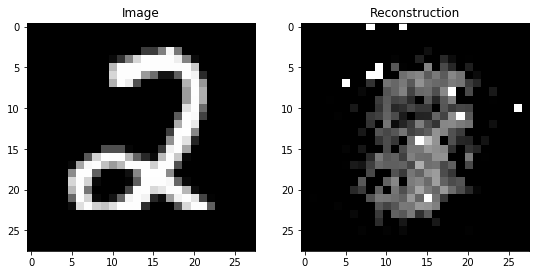

Step 58: Loss: 0.38049575686454773, Accuracy: 0.796875
[-0.         -0.         -0.          0.         -0.         -0.         -0.
 -0.         -0.          0.          0.          0.          0.          0.
 -0.         -0.         -0.33859909 -0.22857931  0.32969975 -0.07705665
  0.06927095 -0.3188144  -0.17328602  0.12587242 -0.15193391  0.05030879
 -0.30039167 -0.0279234   0.4362222  -0.08280021  0.01544613  0.1070744   0.
 -0.         -0.          0.          0.         -0.         -0.          0.
  0.          0.          0.         -0.          0.         -0.          0.
  0.          0.         -0.         -0.          0.         -0.          0.
  0.         -0.         -0.          0.         -0.          0.          0.
  0.         -0.          0.          0.          0.          0.         -0.
 -0.          0.         -0.          0.         -0.          0.          0.
 -0.         -0.         -0.         -0.          0.         -0.          0.
  0.         -0.         -0. 

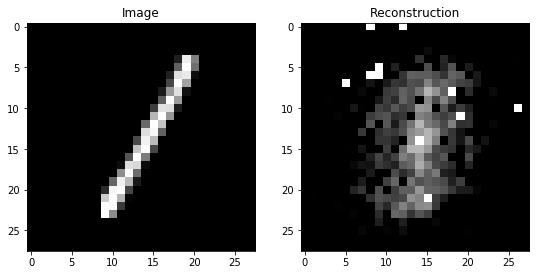

Step 59: Loss: 0.34304213523864746, Accuracy: 0.890625
[ 0.          0.          0.          0.         -0.          0.          0.
  0.          0.         -0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -0.         -0.         -0.          0.          0.
 -0.         -0.          0.          0.         -0.         -0.          0.
  0.          0.          0.         -0.          0.          0.          0.
  0.         -0.         -0.          0.         -0.         -0.         -0.
 -0.         -0.          0.          0.         -0.          0.         -0.
 -0.          0.          0.          0.         -0.         -0.         -0.
  0.         -0.          0.         -0.          0.         -0.          0.
 -0.          0.          0.          0.          0.          0.         -0.
 -0.          0.          0.          0.         -0.         -0.          0.
 -0.          0.     

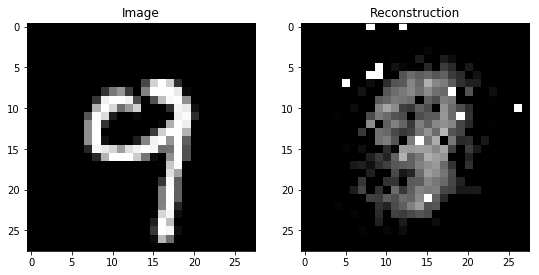

Step 60: Loss: 0.42099815607070923, Accuracy: 0.84375
[ -0.00000000e+00   0.00000000e+00  -0.00000000e+00   0.00000000e+00
   0.00000000e+00  -0.00000000e+00  -0.00000000e+00  -0.00000000e+00
  -0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -0.00000000e+00  -0.00000000e+00
  -2.66873300e-01  -3.04821879e-01   4.12662446e-01  -8.21016729e-02
  -6.33871678e-05  -3.28031868e-01  -2.29826972e-01   2.48738945e-01
  -7.28958249e-02   1.00840397e-01  -1.83729976e-01   4.83372808e-02
   3.66105676e-01  -1.86216205e-01  -3.49157490e-02   9.00312439e-02
  -0.00000000e+00   0.00000000e+00   0.00000000e+00  -0.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -0.00000000e+00   0.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -0.00000000e+00   0.00000000e+00
   0.00000000e+00  -0.00000000e+00  -0.00000000e+00  -0.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -0.00000000e+00  -0.00000000e+00
  -0.00000000e+00   0.00000000e+00   0.00000000e+

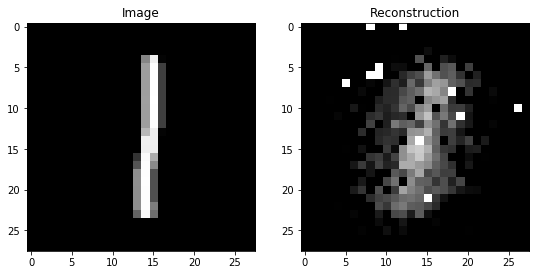

Step 61: Loss: 0.4107484817504883, Accuracy: 0.859375
[ 0.         -0.          0.         -0.         -0.          0.          0.
  0.          0.         -0.          0.         -0.         -0.         -0.
  0.          0.          0.         -0.          0.          0.          0.
  0.          0.         -0.         -0.         -0.         -0.          0.
  0.         -0.         -0.          0.          0.          0.          0.
 -0.         -0.         -0.         -0.          0.         -0.         -0.
 -0.          0.         -0.          0.          0.         -0.         -0.
 -0.         -0.          0.         -0.         -0.         -0.          0.
  0.          0.         -0.          0.          0.          0.          0.
  0.         -0.10776842 -0.0349372  -0.08413279  0.28744054 -0.24985239
  0.1369919  -0.06288474  0.16609931  0.14612448  0.00133042 -0.00569723
  0.25863662 -0.2561897   0.09016123  0.00877628  0.12614766  0.          0.
 -0.          0.          0.  

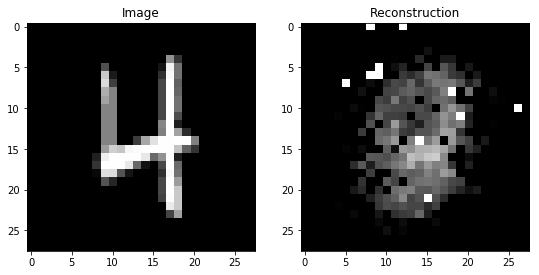

Step 62: Loss: 0.32623186707496643, Accuracy: 0.890625
[ 0.          0.          0.         -0.         -0.          0.          0.
  0.          0.         -0.          0.         -0.         -0.         -0.
  0.          0.          0.         -0.         -0.         -0.          0.
  0.          0.         -0.         -0.         -0.         -0.          0.
  0.         -0.          0.         -0.         -0.          0.          0.
 -0.         -0.          0.          0.         -0.         -0.         -0.
 -0.          0.         -0.          0.         -0.         -0.          0.
 -0.         -0.         -0.          0.         -0.         -0.          0.
 -0.         -0.         -0.         -0.         -0.         -0.          0.
 -0.         -0.         -0.         -0.          0.         -0.          0.
 -0.          0.          0.         -0.          0.          0.         -0.
  0.          0.          0.         -0.         -0.          0.          0.
 -0.         -0.     

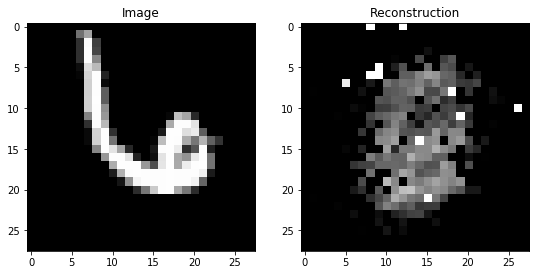

Step 63: Loss: 0.3162040114402771, Accuracy: 0.890625
[-0.         -0.          0.         -0.          0.          0.          0.
  0.         -0.         -0.          0.          0.         -0.         -0.
  0.          0.         -0.22651991 -0.31336462  0.33715835 -0.11571405
 -0.00595385 -0.3431966  -0.18822297  0.24139822 -0.08496214  0.05194425
 -0.1397603   0.08284055  0.39341944 -0.20172241  0.03558992  0.05623526
 -0.         -0.         -0.          0.         -0.         -0.          0.
 -0.          0.          0.          0.         -0.          0.         -0.
 -0.          0.          0.          0.          0.         -0.          0.
 -0.          0.          0.         -0.          0.         -0.          0.
  0.          0.         -0.         -0.          0.          0.         -0.
 -0.          0.         -0.          0.         -0.          0.         -0.
 -0.          0.          0.          0.          0.          0.         -0.
 -0.          0.          0.      

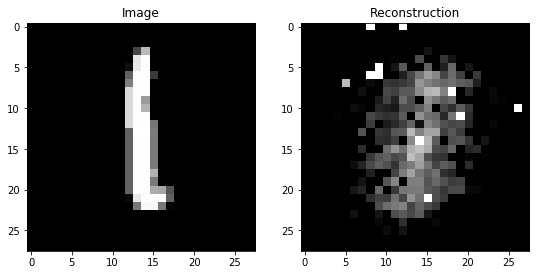

Step 64: Loss: 0.33782273530960083, Accuracy: 0.921875
[ 0.          0.          0.         -0.         -0.          0.          0.
  0.          0.         -0.          0.         -0.         -0.         -0.
  0.          0.          0.          0.          0.         -0.         -0.
 -0.         -0.         -0.         -0.          0.         -0.          0.
  0.         -0.          0.          0.          0.          0.         -0.
  0.         -0.         -0.         -0.         -0.          0.          0.
 -0.          0.         -0.          0.         -0.          0.          0.
  0.          0.          0.         -0.         -0.         -0.         -0.
 -0.          0.         -0.          0.          0.          0.         -0.
 -0.         -0.         -0.          0.         -0.          0.         -0.
 -0.         -0.          0.         -0.         -0.         -0.          0.
  0.         -0.         -0.         -0.          0.         -0.         -0.
  0.          0.     

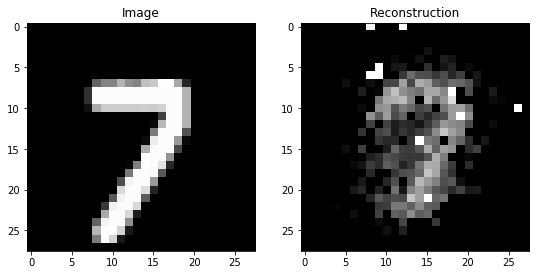

Step 65: Loss: 0.3967339098453522, Accuracy: 0.8359375
[-0.         -0.          0.         -0.          0.          0.          0.
  0.          0.         -0.          0.         -0.          0.          0.
 -0.          0.         -0.         -0.          0.         -0.         -0.
 -0.          0.         -0.          0.         -0.         -0.         -0.
  0.         -0.         -0.          0.          0.          0.          0.
 -0.         -0.         -0.          0.         -0.         -0.         -0.
 -0.          0.         -0.          0.          0.         -0.         -0.
 -0.          0.          0.          0.         -0.         -0.          0.
 -0.          0.          0.         -0.         -0.         -0.          0.
  0.         -0.19459468 -0.09062891 -0.06284565  0.37188977 -0.24975841
  0.20858769 -0.07447357  0.09589683  0.22172789  0.0013511   0.0741909
  0.26206094 -0.26434436  0.21799317 -0.02063924  0.13743874 -0.         -0.
 -0.          0.          0.  

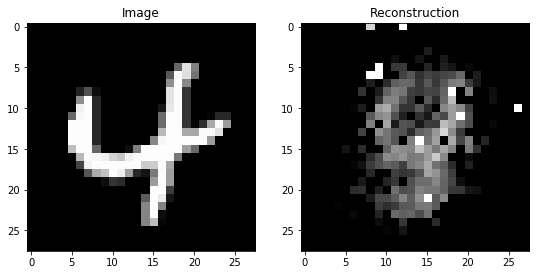

Step 66: Loss: 0.3756774663925171, Accuracy: 0.859375
[ 0.         -0.         -0.          0.          0.         -0.          0.
  0.         -0.          0.         -0.         -0.          0.         -0.
 -0.         -0.          0.          0.         -0.         -0.         -0.
  0.         -0.         -0.         -0.          0.          0.          0.
 -0.          0.          0.          0.          0.          0.          0.
  0.         -0.          0.          0.         -0.          0.          0.
 -0.          0.         -0.         -0.         -0.         -0.          0.
  0.         -0.          0.         -0.          0.          0.         -0.
  0.         -0.         -0.          0.          0.          0.         -0.
 -0.         -0.         -0.          0.          0.          0.          0.
 -0.          0.          0.          0.         -0.          0.         -0.
  0.          0.         -0.          0.          0.          0.          0.
  0.          0.      

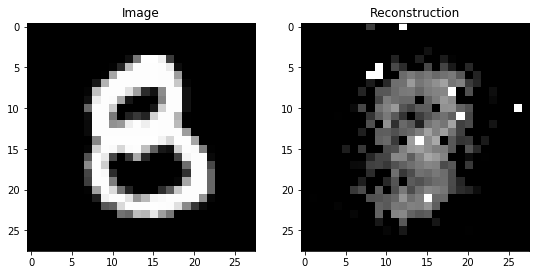

Step 67: Loss: 0.38467779755592346, Accuracy: 0.875
[-0.         -0.         -0.         -0.          0.         -0.          0.
 -0.          0.         -0.          0.         -0.         -0.         -0.
  0.          0.          0.         -0.          0.         -0.          0.
  0.         -0.         -0.          0.         -0.          0.          0.
 -0.          0.          0.          0.         -0.          0.         -0.
  0.          0.         -0.         -0.         -0.          0.          0.
 -0.          0.         -0.         -0.         -0.          0.         -0.
 -0.          0.          0.          0.          0.         -0.         -0.
 -0.         -0.         -0.         -0.          0.          0.          0.
  0.         -0.         -0.          0.         -0.          0.         -0.
 -0.         -0.         -0.          0.          0.         -0.          0.
 -0.          0.          0.          0.          0.          0.         -0.
 -0.         -0.        

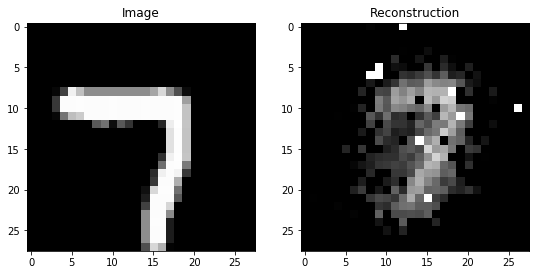

Step 68: Loss: 0.366748571395874, Accuracy: 0.8828125
[ 0.          0.         -0.          0.         -0.          0.          0.
  0.          0.          0.         -0.          0.          0.          0.
 -0.          0.          0.         -0.         -0.         -0.         -0.
  0.         -0.         -0.         -0.         -0.          0.          0.
  0.         -0.          0.          0.         -0.         -0.          0.
  0.         -0.         -0.         -0.          0.          0.          0.
  0.         -0.          0.         -0.         -0.          0.         -0.
 -0.         -0.          0.         -0.          0.          0.         -0.
  0.          0.          0.          0.         -0.          0.         -0.
  0.         -0.          0.         -0.          0.         -0.          0.
  0.          0.          0.          0.          0.          0.         -0.
  0.          0.          0.          0.          0.         -0.         -0.
  0.          0.      

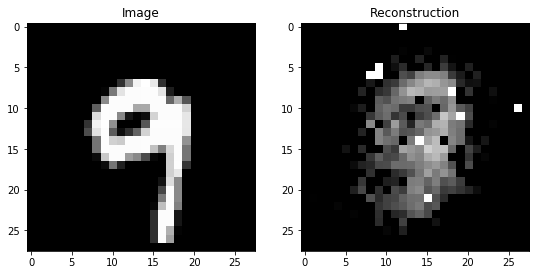

Step 69: Loss: 0.333529531955719, Accuracy: 0.8828125
[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -0.          0.         -0.
 -0.          0.          0.          0.         -0.          0.          0.
  0.         -0.         -0.         -0.          0.          0.          0.
  0.         -0.          0.         -0.          0.          0.          0.
  0.         -0.         -0.         -0.          0.          0.         -0.
 -0.          0.         -0.          0.          0.          0.          0.
  0.         -0.          0.         -0.          0.         -0.         -0.
 -0.          0.          0.          0.         -0.          0.         -0.
 -0.         -0.         -0.         -0.          0.         -0.          0.
  0.          0.          0.          0.          0.          0.         -0.
  0.          0.          0.          0.         -0.         -0.          0.
  0.          0.      

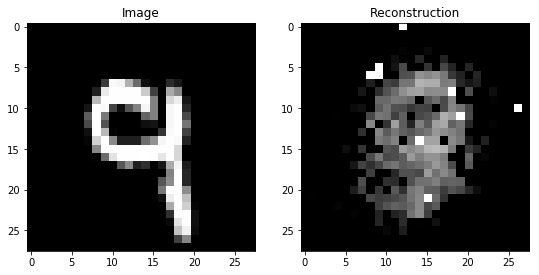

Step 70: Loss: 0.34014445543289185, Accuracy: 0.8671875
[ 0.         -0.         -0.          0.          0.         -0.         -0.
 -0.         -0.          0.         -0.         -0.          0.          0.
 -0.         -0.          0.          0.         -0.          0.         -0.
  0.          0.         -0.          0.         -0.         -0.         -0.
 -0.          0.          0.         -0.         -0.         -0.         -0.
  0.          0.         -0.         -0.         -0.          0.          0.
  0.         -0.          0.          0.         -0.          0.         -0.
  0.         -0.          0.         -0.          0.          0.         -0.
  0.          0.          0.         -0.          0.          0.         -0.
 -0.          0.          0.          0.         -0.          0.         -0.
 -0.         -0.         -0.          0.         -0.         -0.          0.
 -0.          0.         -0.          0.03846176 -0.0497131   0.17859226
  0.1900401   0.09342997

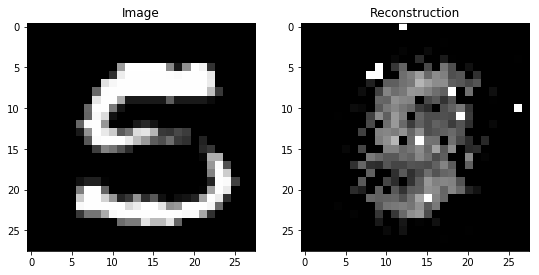

Step 71: Loss: 0.34596043825149536, Accuracy: 0.8671875
[ 0.06575384 -0.07584546 -0.07721721  0.1620672   0.2155975  -0.29903001
 -0.02197338 -0.25234362 -0.29476455  0.05000596 -0.36207786 -0.09758592
  0.19728431  0.01581293 -0.23176739 -0.3301276   0.          0.         -0.
  0.          0.          0.         -0.          0.         -0.          0.
  0.         -0.          0.          0.          0.         -0.         -0.
  0.         -0.          0.          0.          0.         -0.         -0.
  0.          0.          0.         -0.          0.          0.         -0.
  0.         -0.          0.         -0.          0.          0.          0.
  0.         -0.         -0.         -0.         -0.         -0.          0.
 -0.         -0.         -0.          0.          0.          0.         -0.
  0.         -0.         -0.         -0.         -0.          0.         -0.
 -0.          0.         -0.          0.         -0.         -0.         -0.
  0.          0.          0.

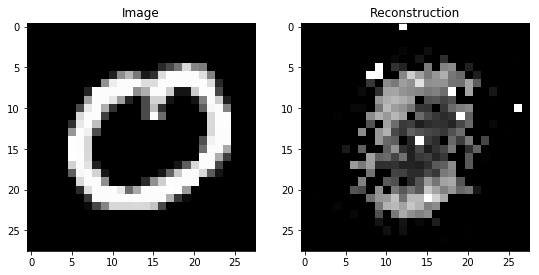

Step 72: Loss: 0.36415979266166687, Accuracy: 0.8828125
[ 0.         -0.         -0.          0.          0.         -0.         -0.
 -0.         -0.          0.         -0.         -0.          0.          0.
 -0.         -0.          0.          0.         -0.          0.         -0.
  0.          0.         -0.          0.          0.          0.         -0.
 -0.          0.          0.         -0.          0.01364921  0.20797512
  0.13420598 -0.32967472 -0.13737589  0.03840832 -0.14143488  0.00640634
 -0.09626498 -0.30423704 -0.44237378  0.14734346 -0.2088787  -0.02990269
  0.00950245 -0.05683668  0.          0.         -0.         -0.         -0.
  0.          0.         -0.          0.         -0.          0.          0.
  0.          0.          0.         -0.         -0.         -0.         -0.
  0.         -0.          0.          0.          0.          0.          0.
  0.          0.         -0.         -0.         -0.          0.         -0.
 -0.         -0.         -0.    

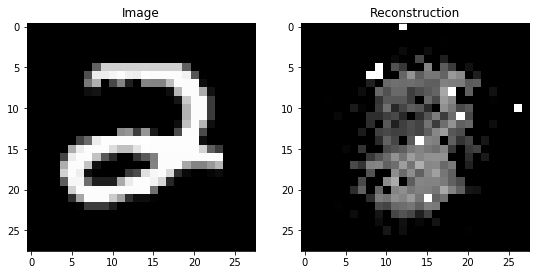

Step 73: Loss: 0.34903228282928467, Accuracy: 0.8828125
[ 0.         -0.          0.          0.         -0.         -0.         -0.
  0.         -0.          0.         -0.         -0.         -0.         -0.
 -0.         -0.          0.          0.         -0.          0.         -0.
  0.          0.          0.          0.          0.          0.          0.
 -0.          0.          0.         -0.          0.         -0.          0.
  0.          0.          0.         -0.         -0.          0.          0.
  0.         -0.         -0.          0.         -0.          0.          0.
  0.          0.          0.          0.         -0.         -0.         -0.
 -0.          0.          0.         -0.          0.         -0.          0.
  0.          0.         -0.         -0.         -0.          0.         -0.
  0.          0.         -0.         -0.          0.          0.          0.
  0.          0.          0.         -0.0283728  -0.12435791  0.01944295
  0.08033361  0.02526188

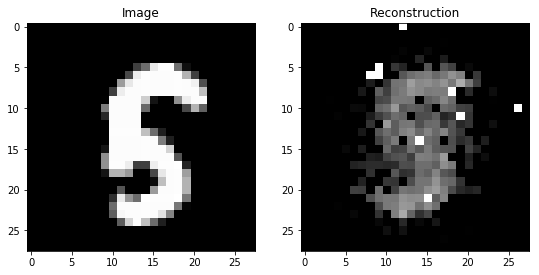

Step 74: Loss: 0.3682186007499695, Accuracy: 0.8828125
[ 0.         -0.         -0.          0.         -0.         -0.         -0.
  0.         -0.          0.         -0.         -0.         -0.         -0.
  0.         -0.          0.          0.         -0.          0.          0.
  0.          0.         -0.          0.          0.          0.         -0.
 -0.          0.         -0.         -0.          0.          0.          0.
 -0.          0.          0.         -0.         -0.         -0.         -0.
 -0.          0.         -0.          0.         -0.          0.          0.
 -0.          0.         -0.          0.         -0.         -0.          0.
  0.         -0.          0.         -0.          0.         -0.          0.
  0.         -0.         -0.          0.          0.         -0.         -0.
  0.          0.          0.         -0.          0.          0.         -0.
  0.         -0.         -0.         -0.         -0.          0.          0.
  0.          0.     

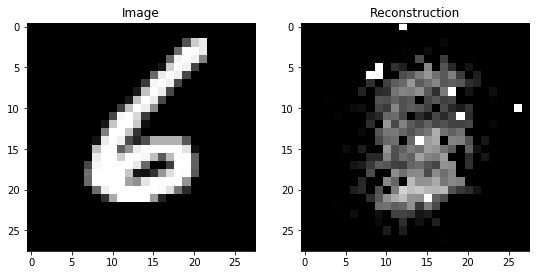

Step 75: Loss: 0.33812248706817627, Accuracy: 0.890625
[ 0.         -0.         -0.          0.         -0.         -0.         -0.
 -0.         -0.          0.         -0.         -0.          0.         -0.
 -0.         -0.          0.          0.         -0.         -0.         -0.
  0.          0.         -0.          0.         -0.          0.         -0.
 -0.          0.         -0.         -0.          0.          0.          0.
  0.         -0.          0.         -0.         -0.         -0.          0.
 -0.          0.         -0.         -0.          0.         -0.          0.
  0.         -0.          0.          0.          0.          0.         -0.
  0.          0.         -0.          0.          0.          0.          0.
 -0.         -0.          0.         -0.          0.          0.          0.
 -0.         -0.          0.         -0.          0.         -0.          0.
  0.          0.         -0.          0.         -0.          0.          0.
  0.          0.     

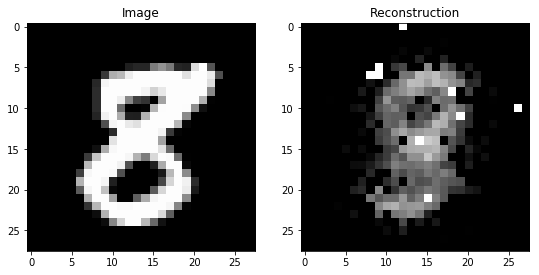

Step 76: Loss: 0.28458744287490845, Accuracy: 0.921875
[ 0.          0.          0.          0.         -0.          0.         -0.
  0.         -0.          0.          0.          0.          0.         -0.
  0.          0.          0.          0.         -0.         -0.         -0.
  0.         -0.         -0.          0.         -0.          0.         -0.
 -0.          0.          0.         -0.          0.         -0.          0.
 -0.          0.          0.          0.         -0.          0.          0.
  0.         -0.          0.         -0.         -0.         -0.          0.
  0.         -0.         -0.          0.          0.          0.         -0.
 -0.          0.          0.          0.          0.          0.         -0.
 -0.         -0.          0.         -0.          0.         -0.          0.
 -0.          0.          0.          0.          0.          0.         -0.
  0.         -0.          0.          0.         -0.         -0.         -0.
  0.          0.     

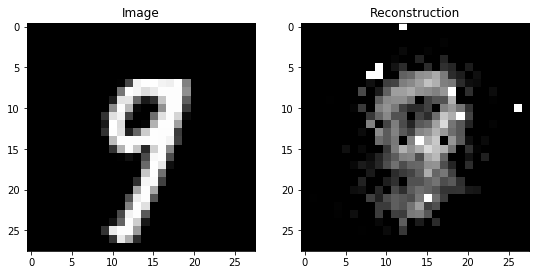

Step 77: Loss: 0.33556604385375977, Accuracy: 0.859375
[ 0.         -0.          0.         -0.         -0.         -0.         -0.
 -0.         -0.          0.         -0.          0.          0.          0.
  0.         -0.          0.         -0.         -0.         -0.         -0.
  0.          0.         -0.          0.          0.         -0.          0.
 -0.          0.         -0.          0.          0.          0.         -0.
 -0.         -0.         -0.          0.         -0.          0.          0.
 -0.          0.         -0.         -0.         -0.         -0.         -0.
  0.         -0.          0.          0.         -0.          0.         -0.
  0.          0.         -0.          0.          0.         -0.         -0.
  0.         -0.         -0.         -0.          0.         -0.          0.
 -0.          0.          0.         -0.          0.          0.         -0.
  0.         -0.          0.          0.03639423 -0.08086537  0.14860943
  0.15228966  0.06085805 

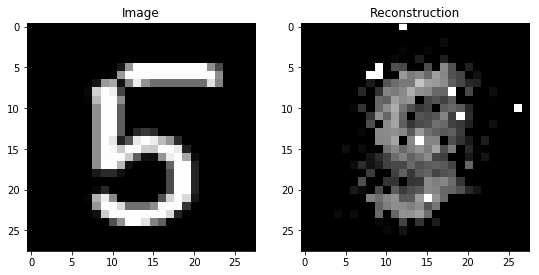

Step 78: Loss: 0.334713876247406, Accuracy: 0.8828125
[-0.         -0.         -0.          0.          0.         -0.         -0.
 -0.         -0.         -0.          0.          0.          0.         -0.
 -0.          0.         -0.32578966 -0.29842007  0.36576265 -0.1059896
  0.03849699 -0.33591154 -0.14606842  0.16034685 -0.15448084  0.06882851
 -0.26261169  0.01174535  0.44809008 -0.12249593 -0.00761897  0.12519091
  0.         -0.         -0.          0.          0.         -0.          0.
  0.         -0.          0.          0.          0.          0.         -0.
 -0.         -0.         -0.          0.         -0.         -0.          0.
  0.         -0.          0.         -0.          0.         -0.          0.
  0.          0.         -0.          0.         -0.          0.         -0.
  0.         -0.          0.         -0.          0.          0.         -0.
 -0.          0.         -0.          0.         -0.          0.         -0.
 -0.          0.          0.       

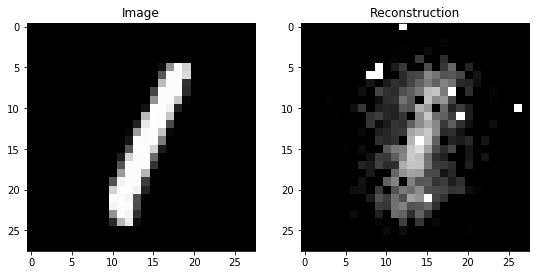

Step 79: Loss: 0.3641818165779114, Accuracy: 0.84375
[-0.         -0.          0.          0.          0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.          0.          0.
 -0.         -0.         -0.         -0.          0.         -0.         -0.
 -0.         -0.          0.         -0.         -0.          0.          0.
  0.         -0.          0.         -0.          0.          0.          0.
  0.         -0.         -0.          0.         -0.          0.          0.
 -0.          0.          0.         -0.         -0.         -0.         -0.
 -0.          0.         -0.          0.         -0.         -0.          0.
 -0.          0.         -0.          0.         -0.         -0.          0.
  0.         -0.          0.         -0.          0.         -0.          0.
  0.          0.          0.         -0.          0.          0.         -0.
 -0.          0.          0.          0.          0.          0.          0.
 -0.         -0.       

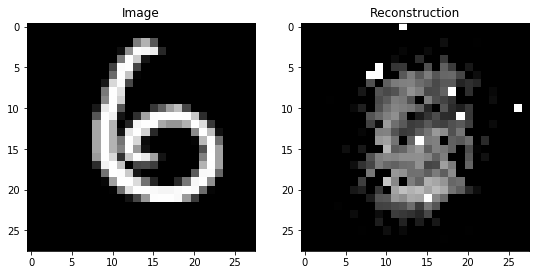

Step 80: Loss: 0.3096049427986145, Accuracy: 0.890625
[-0.          0.         -0.         -0.          0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.          0.          0.
  0.         -0.          0.          0.         -0.          0.         -0.
  0.          0.         -0.          0.          0.          0.          0.
 -0.          0.         -0.         -0.          0.00583324  0.28855208
  0.19654933 -0.2763249  -0.15105906  0.04965828 -0.12190172  0.01964564
 -0.04783618 -0.32315063 -0.53864527  0.12119094 -0.16205522 -0.10968983
 -0.02370425 -0.06979149 -0.         -0.         -0.          0.         -0.
 -0.         -0.         -0.         -0.          0.         -0.          0.
  0.         -0.          0.          0.         -0.         -0.         -0.
  0.         -0.          0.         -0.          0.          0.         -0.
  0.          0.          0.          0.          0.         -0.         -0.
 -0.         -0.         -0.      

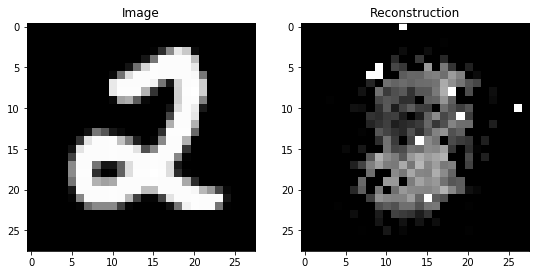

KeyboardInterrupt: 

In [13]:
#train_writer = tf.summary.FileWriter("./summaries/train", tf.get_default_graph())

with tf.Session() as sess:
    step = 0
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(10):
        batch_generator = mnist_data.get_training_batch(batch_size)
        
        for x, y in batch_generator:
            _loss, _accuracy, _, _rec, d  = sess.run([loss,
                                            accuracy,
                                            training_step,
                                            reconstructions,
                                            digit_caps_flat],
                                            feed_dict = {images: x,
                                                        labels: y})
            #train_writer.add_summary(_summaries, step)
            step += 1
            print("Step {}: Loss: {}, Accuracy: {}".format(step, _loss, _accuracy))
            print(d[0])
            # for validation plot a image and its reconstruction
            fig = plt.figure(figsize = (9,5))
            fig.add_subplot(1,2,1)
            plt.imshow(x[0], cmap='gray')
            plt.title('Image')
            fig.add_subplot(1,2,2)
            plt.imshow(_rec[0], cmap='gray')
            plt.title('Reconstruction')
            plt.show()
            
            